# Pacotes úteis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore');

from statsmodels.tsa.seasonal import seasonal_decompose as stl
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg as AR
from sklearn.tree import DecisionTreeRegressor as dt
from itertools import product
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score

from statsmodels.tsa.statespace.sarimax import SARIMAX as sr
from numpy import log
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import random
random.seed(12345)

from sklearn.metrics import r2_score


from sklearn.model_selection import cross_val_score as crv

from math import log

import statsmodels.api as sm

import seaborn as sns

# EDA



## Carregando o dataset

In [2]:
df = pd.read_excel("DadosBA.xlsx", sheet_name = None)
df = pd.concat([df['2018'],df['2019'],df['2020']]) # Concatenar data from 2018 and 2020 dataframes
# df = pd.concat([df['2020']]) # Concatenar data from 2018 and 2020 dataframes
df.set_index('Timestamp', inplace = True) #set timestamps as index
df


,BAIRRO ALTO - / FREQ B1,BAIRRO ALTO - / FREQ B2,BAIRRO ALTO - / FREQ B3,BAIRRO ALTO - LT01 / NÍVEL,BAIRRO ALTO - FT01 / ENT IRAI,BAIRRO ALTO - FT02 / GBAL,BAIRRO ALTO - FT03 / RBAL,BAIRRO ALTO - PT01 / SUCÇÃO,BAIRRO ALTO - PT02 / RBAL
Timestamp,,,,,,,,,
2018-01-01 00:00:00,39.716118,0,0,4.027903,270.285187,76.920532,61.992577,5.232423,13.961227
2018-01-01 01:00:00,40.692509,0,0,4.241524,268.635803,83.023201,66.538521,5.431031,13.961227
2018-01-01 02:00:00,34.512108,0,0,4.352295,0,82.35186,57.269573,5.555567,11.049756
2018-01-01 03:00:00,33.531471,0,0,4.136808,0,69.360985,52.244926,5.358496,11.115347
2018-01-01 04:00:00,33.191261,0,0,3.947308,0,59.742775,49.71859,5.184939,11.180938
...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,57.988792,46.797836,0,3.669613,0.115741,149.436783,121.814819,4.499011,23.046875
2020-12-31 20:00:00,57.988792,47.061192,0,3.221217,0.115741,151.018051,117.933388,4.070826,23.046875
2020-12-31 21:00:00,0,45.869583,57.988792,2.803498,0.115741,129.294189,106.692932,3.714235,21.976273


In [3]:
filtro = (df.index.year>=2020)
df = df[filtro]
filtro = (df.index.year<=2020)
df = df[filtro]
# filtro = (df.index.hour>=18)
# df = df[filtro]
# filtro = (df.index.hour<=21)
# df = df[filtro]

hora = '24h'

df.isna().any() # verifique se não há valores NAN
df = df.rename(columns={'BAIRRO ALTO -  / FREQ B1': 'FREQUENCIA BOMBA 1',
                        'BAIRRO ALTO -  / FREQ B2': 'FREQUENCIA BOMBA 2',
                        'BAIRRO ALTO -  / FREQ B3':'FREQUENCIA BOMBA 3',
                        'BAIRRO ALTO - LT01 / NÍVEL':'NIVEL DO RESERVATÓRIO - LT01',
                        'BAIRRO ALTO - FT01 / ENT IRAI':'VAZÃO DE ENTRADA- FT01',
                        'BAIRRO ALTO - FT02 / GBAL':'VAZÃO DE GRAVIDADE - FT02',
                        'BAIRRO ALTO - FT03 / RBAL':'VAZÃO DE RECALQUE - FT03',
                        'BAIRRO ALTO - PT01 / SUCÇÃO':'PRESSÃO DE SUCÇÃO - PT01',
                        'BAIRRO ALTO - PT02 / RBAL':'PRESSÃO DE RECALQUE - PT02'})
df

,FREQUENCIA BOMBA 1,FREQUENCIA BOMBA 2,FREQUENCIA BOMBA 3,NIVEL DO RESERVATÓRIO - LT01,VAZÃO DE ENTRADA- FT01,VAZÃO DE GRAVIDADE - FT02,VAZÃO DE RECALQUE - FT03,PRESSÃO DE SUCÇÃO - PT01,PRESSÃO DE RECALQUE - PT02
Timestamp,,,,,,,,,
2020-01-01 00:00:00,49.951782,0,0,2.643318,273.185211,85.701103,79.184425,3.664382,18.012152
2020-01-01 01:00:00,47.219151,0,0,2.829842,274.458099,89.969772,76.836655,3.875102,16.036293
2020-01-01 02:00:00,46.423992,0,0,3.009788,276.010712,84.161751,74.90699,4.064512,15.943287
2020-01-01 03:00:00,44.882751,0,0,3.231261,278.503448,67.038933,68.703079,4.304618,15.969937
2020-01-01 04:00:00,44.022583,0,0,3.47608,281.190247,60.943451,66.032722,4.556703,16.041798
...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,57.988792,46.797836,0,3.669613,0.115741,149.436783,121.814819,4.499011,23.046875
2020-12-31 20:00:00,57.988792,47.061192,0,3.221217,0.115741,151.018051,117.933388,4.070826,23.046875
2020-12-31 21:00:00,0,45.869583,57.988792,2.803498,0.115741,129.294189,106.692932,3.714235,21.976273


In [4]:
df.replace(to_replace='Bad',value=np.nan,inplace=True)
df.isna().any() # verifique se existem valores NAN (sequências 'Bad' substituídas)
df.interpolate(inplace=True)

df = df.dropna()

# 24 horas

df = df.resample('24h').mean()
# df = df.resample('24h').min()
# df2 = df.resample('24h', offset = "19h").mean()
# df3 = df.resample('24h', offset = "20h").mean()
# df4 = df.resample('24h', offset = "21h").mean()
df.shape

(366, 9)

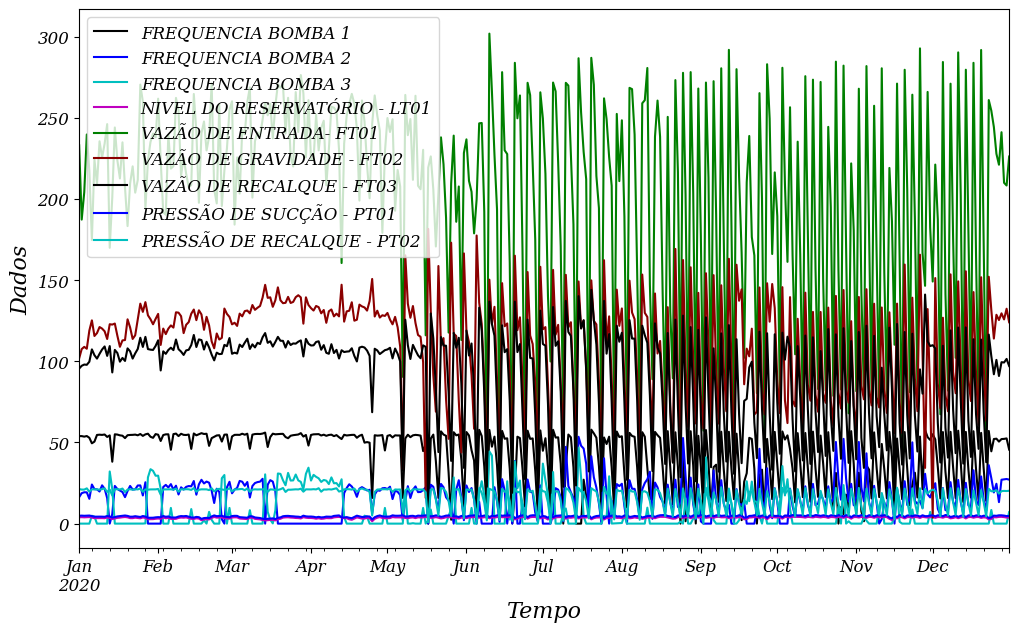

In [5]:

font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
# gráfico de linha
df.plot(figsize = (12,7), color = ['k', 'b', 'c', 'm', 'g', 'darkred'])
plt.xlabel('Tempo', fontsize = 16)
plt.ylabel("Dados", fontsize = 16)
plt.legend(loc = 2)
plt.savefig("dados todo.pdf", dpi=500)
plt.show()


# Treino, test e validação


In [6]:
#%% Divide os dados em treinamento, validação e teste
# 70% para treinamento e validação (18.414 amostras) e 30% para teste (7.892 amostras)
# Das 18.414 amostras, 80% para treinamento (14.731 amostras) e 20% para validação (3.683 amostras)

# thresholds
trn_samples = int((len(df)*70/100)*(80/100))
vld_samples = int((len(df)*70/100)*(20/100))
tst_samples = int((len(df)*30/100))

trn = df.iloc[:trn_samples]
vld = df.iloc[trn_samples:trn_samples+vld_samples]
tst = df.iloc[trn_samples+vld_samples:]

endog_tst = tst['NIVEL DO RESERVATÓRIO - LT01']
exog_tst = tst[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3'
                , 'VAZÃO DE ENTRADA- FT01', 'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog_tst = tst['PRESSÃO DE SUCÇÃO - PT01']

endog_vld = vld['NIVEL DO RESERVATÓRIO - LT01']
exog_vld = vld[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3',
       'VAZÃO DE ENTRADA- FT01',
       'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog_vld = vld['PRESSÃO DE SUCÇÃO - PT01']
       
endog_trn = trn['NIVEL DO RESERVATÓRIO - LT01']
exog_trn = trn[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3',
       'VAZÃO DE ENTRADA- FT01',
       'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog_trn = trn['PRESSÃO DE SUCÇÃO - PT01']


endog = df['NIVEL DO RESERVATÓRIO - LT01']
exog = df[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3'
                , 'VAZÃO DE ENTRADA- FT01', 'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog = df['PRESSÃO DE SUCÇÃO - PT01']

rt = 'LT01 (m³)'

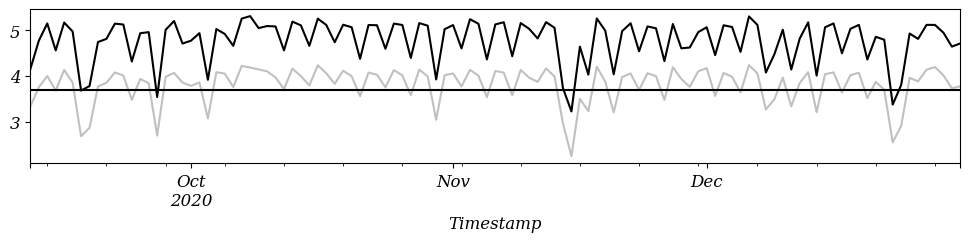

In [7]:
plt.figure(figsize = (12,2))
tst['NIVEL DO RESERVATÓRIO - LT01'].plot(color = 'silver')
tst['PRESSÃO DE SUCÇÃO - PT01'].plot(color = 'black')
plt.axhline(y=3.7, color = 'black')
plt.show()

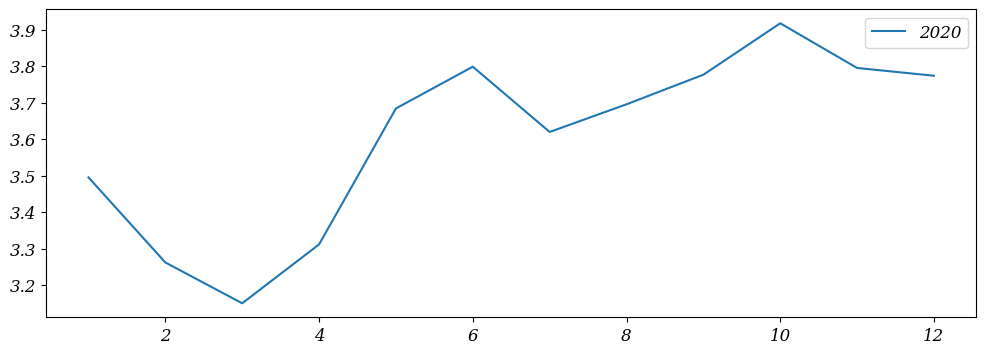

In [8]:

## Agrupando por ano
idx_year = df.index.year
idx_month = df.index.month
plt.figure(figsize = (12,4))
plt.plot(endog.groupby(by = [idx_year, idx_month]).mean().unstack(level = 0))
# plt.title('Agruapdo por Ano')
# plt.legend(['2018','2019', '2020'])
plt.legend(['2020'])
plt.savefig(f"media-agrupada.pdf", dpi=500)
plt.show()

## Diferença com o valor anterior

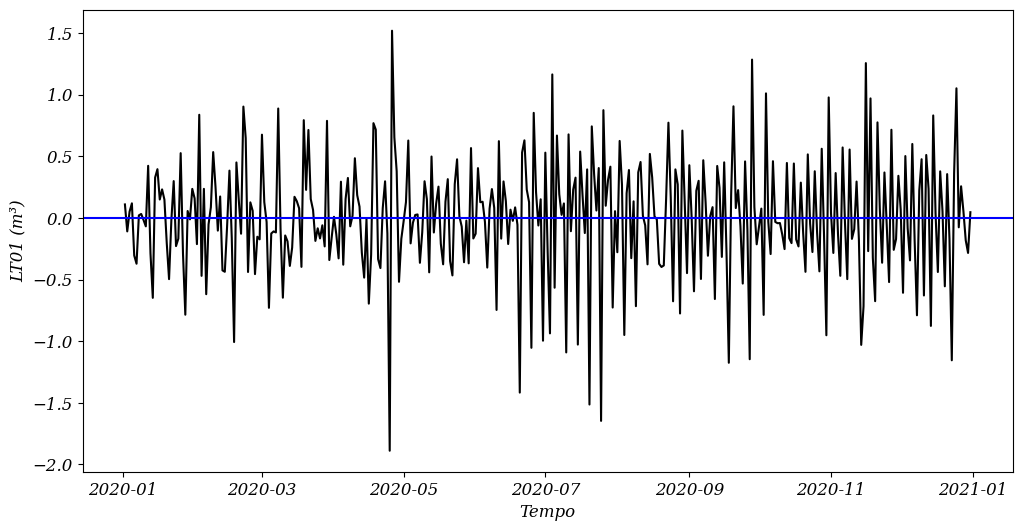

In [143]:

plt.figure(figsize = (12,6))

font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog.diff(), 'black')
plt.axhline(y=0, color = 'b')
plt.ylabel(rt)
plt.xlabel("Tempo")
plt.savefig("estacionaridade.pdf", dpi=500)
plt.show()

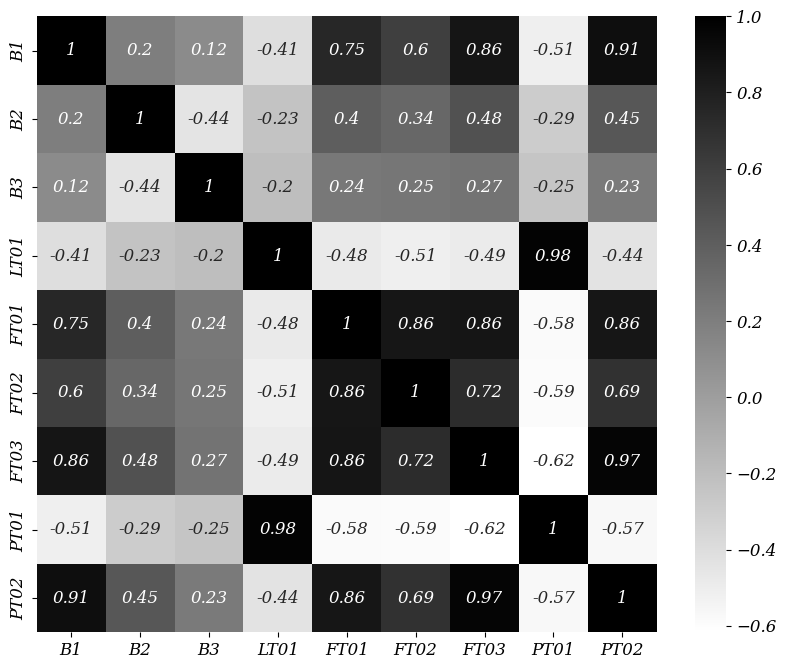

In [10]:
df2 = df.rename(columns={'FREQUENCIA BOMBA 1': 'B1',
                        'FREQUENCIA BOMBA 2': 'B2',
                        'FREQUENCIA BOMBA 3': 'B3',
                        'NIVEL DO RESERVATÓRIO - LT01': 'LT01',
                        'VAZÃO DE ENTRADA- FT01': 'FT01',
                        'VAZÃO DE GRAVIDADE - FT02': 'FT02',
                        'VAZÃO DE RECALQUE - FT03': 'FT03',
                        'PRESSÃO DE SUCÇÃO - PT01': 'PT01',
                        'PRESSÃO DE RECALQUE - PT02': 'PT02'})

plt.figure(figsize = (10,8))
sns.color_palette(as_cmap = True)
sns.heatmap(df2.corr(method = 'pearson'), annot = True, cmap = 'binary')
plt.savefig(f"person.pdf", dpi=500)
plt.show()

In [11]:
# from pandas_profiling import ProfileReport
# import sweetviz as sv

# # EDA using pandas-profiling
# profile = ProfileReport(df, explorative=True)

# #Saving results to a HTML file
# profile.to_file("output.html")

# # EDA using Autoviz
# sweet_report = sv.analyze(df)

# #Saving results to HTML file
# sweet_report.show_html('sweet_report.html')


In [12]:
# plt.plot(df2.LT01)

In [13]:

# import dtale


# dtale.show(df2)

In [14]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# s = df2['LT01']
# sd_result = seasonal_decompose(s, model='additive')

In [15]:
from statsmodels.tsa.filters.hp_filter import hpfilter

s = df['NIVEL DO RESERVATÓRIO - LT01']
cycle, trend = hpfilter(s, lamb=1600)

In [16]:
# sd_result.plot();

# Ruido branco

In [17]:
df.mean()

FREQUENCIA BOMBA 1               41.932082
FREQUENCIA BOMBA 2               15.780640
FREQUENCIA BOMBA 3                6.213367
NIVEL DO RESERVATÓRIO - LT01      3.607910
VAZÃO DE ENTRADA- FT01          203.938601
VAZÃO DE GRAVIDADE - FT02       111.756895
VAZÃO DE RECALQUE - FT03         92.048801
PRESSÃO DE SUCÇÃO - PT01          4.559932
PRESSÃO DE RECALQUE - PT02       16.832988
dtype: float64

In [18]:
df2.mean().to_excel('media.xlsx')


In [19]:
df2.describe().to_excel('estatistica.xlsx')

In [20]:
df.describe()

,FREQUENCIA BOMBA 1,FREQUENCIA BOMBA 2,FREQUENCIA BOMBA 3,NIVEL DO RESERVATÓRIO - LT01,VAZÃO DE ENTRADA- FT01,VAZÃO DE GRAVIDADE - FT02,VAZÃO DE RECALQUE - FT03,PRESSÃO DE SUCÇÃO - PT01,PRESSÃO DE RECALQUE - PT02
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,41.932082,15.780640,6.213367,3.607910,203.938601,111.756895,92.048801,4.559932,16.832988
std,17.624569,11.487194,10.851065,0.484313,65.822557,32.625729,30.560818,0.556846,6.323931
min,0.000000,0.000000,0.000000,1.458840,22.853874,3.583976,10.383355,2.599595,0.830832
25%,33.595225,6.385696,0.000000,3.348583,176.923214,87.527397,73.518915,4.224368,13.197534
50%,52.689572,16.350328,0.000000,3.739742,221.326770,122.669581,105.688277,4.663154,20.196981
75%,54.726129,23.106649,8.636337,3.991530,252.288323,132.938204,112.034394,5.014959,21.119525
max,57.884742,53.488396,46.841334,4.255611,301.862820,181.565478,143.988415,5.475387,22.693986



# Métodos preditivos

In [21]:

from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df2.LT01.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -2.983421
p-value: 0.036472


<Figure size 1200x200 with 0 Axes>

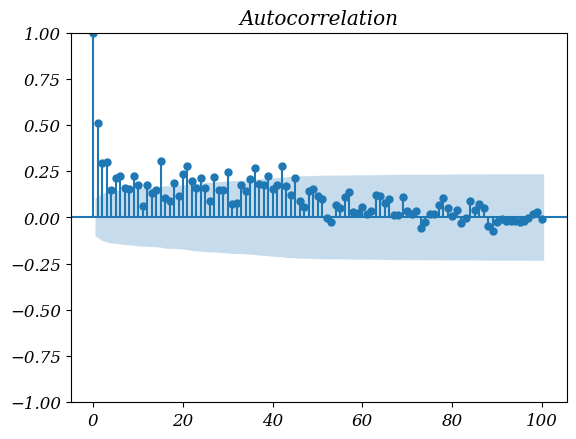

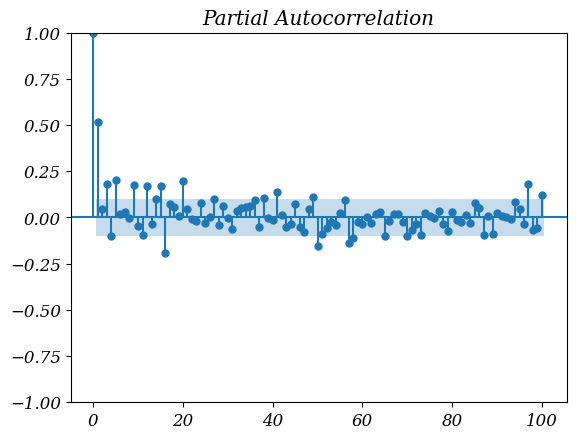

In [22]:

plt.figure(figsize = (12,2))
plot_acf(endog,lags=100)
plot_pacf(endog,lags=100)
plt.show()


## Estacionalidade


In [23]:

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Passa numa série cronológica e num título opcional, devolve um relatório ADF
    """
    print(f'Teste de Dickey-Fuller Aumentado: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['Estatística de teste ADF', 'p-valor', '# atrasos utilizados', '# observações']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'valor crítico ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Fortes provas contra a hipótese nula")
        print("Rejeitar a hipótese nula")
        print("Os dados não têm raiz unitária e são estacionários")
    else:
        print("Fracas provas contra a hipótese nula")
        print("Não rejeitar a hipótese nula")
        print("Os dados têm uma raiz unitária e não são estacionários")


adf_test(endog)


Teste de Dickey-Fuller Aumentado: 
Estatística de teste ADF     -2.983421
p-valor                       0.036472
# atrasos utilizados         15.000000
# observações               350.000000
valor crítico (1%)           -3.449173
valor crítico (5%)           -2.869833
valor crítico (10%)          -2.571188
Fortes provas contra a hipótese nula
Rejeitar a hipótese nula
Os dados não têm raiz unitária e são estacionários


# Decomposição STL

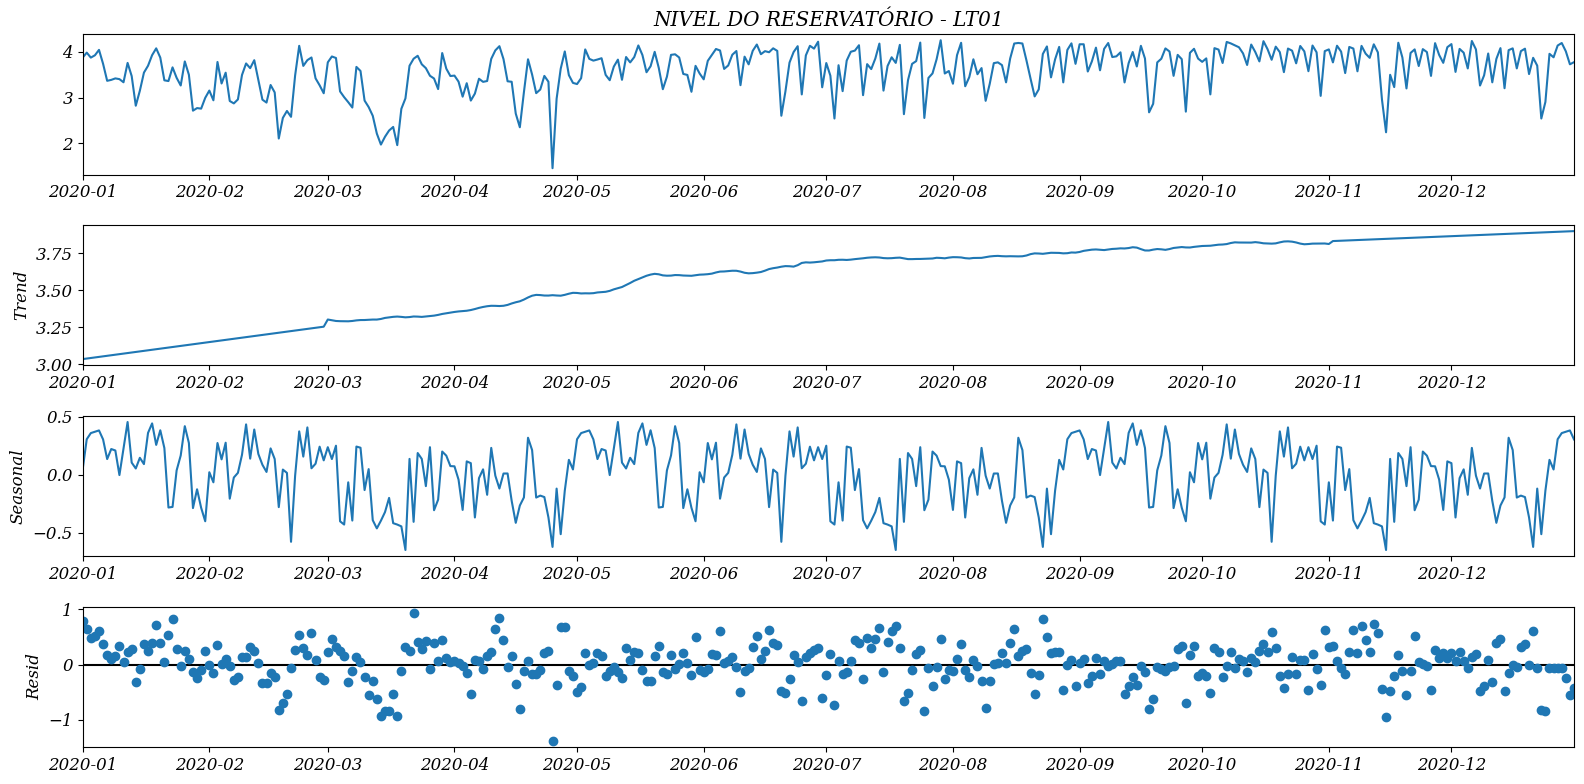

In [120]:

rst = stl(endog, model='add', extrapolate_trend='freq', period=10*12)
rcParams['figure.figsize'] = 16,8 # aumentar o tamanho do grafico
rst.plot()
plt.show()


<Figure size 1500x600 with 0 Axes>

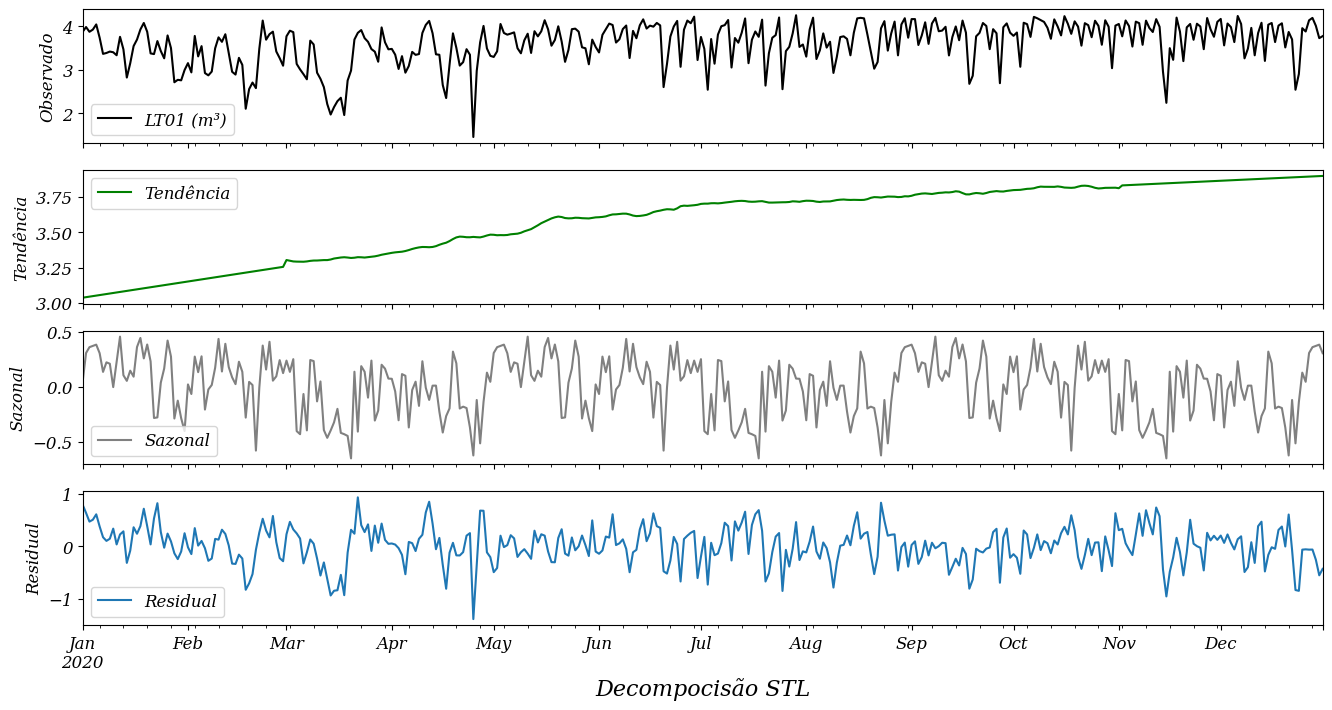

In [121]:
plt.figure(figsize = (15,6))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
fig, axes = plt.subplots(4, 1, sharex=True)
rcParams['figure.figsize'] = 16,8 # aumentar o tamanho do grafico
rst.observed.plot(ax=axes[0], legend=True, label = rt, color='black')
axes[0].set_ylabel('Observado')
rst.trend.plot(ax=axes[1], legend=True, label = 'Tendência', color='g')
axes[1].set_ylabel('Tendência')
rst.seasonal.plot(ax=axes[2], legend=True, label = 'Sazonal', color = 'gray')
axes[2].set_ylabel('Sazonal')
rst.resid.plot(ax=axes[3], legend=True, label = 'Residual')
axes[3].set_ylabel('Residual')
plt.xlabel( 'Decompocisão STL', fontsize = 16)
plt.savefig("STL.pdf", dpi=500)
plt.show()


In [27]:


from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(endog)


(0.01, False)

In [28]:
# ## Auto ARIMA 
# from pmdarima import auto_arima
# stepwise_fit = auto_arima(endog_trn, start_p=0, start_q=0,
#                           max_p=7, max_q=7, m=12,
#                           start_P=0, seasonal=True,
#                           d=1, D=1, trace=True,
#                           error_action='ignore',   # não queremos saber se uma encomenda não funciona
#                           suppress_warnings=True,  # não queremos avisos de convergência
#                           stepwise=True)           # programado para escalonar
# stepwise_fit.summary()


## Modelo atualizado

In [29]:
# arima = str(stepwise_fit)
# best= pd.DataFrame({'p' : [arima[7]],
# 'd':[arima[9]],'q':[arima[11]],
# 'P' : [arima[14]],'D':[arima[16]],'Q':[arima[18]],'M':[arima[21]+arima[22]]},
# index=['Melhor Modelo'],)
# best.to_excel('best.xlsx')
# best

In [30]:
# arima = str(stepwise_fit)
# best= pd.DataFrame({'p' : [arima[7]],
# 'd':[arima[9]],'q':[arima[11]],
# 'P' : [arima[14]],'D':[arima[16]],'Q':[arima[18]],'M':[arima[21]]},
# index=['Melhor Modelo'],)
# best.to_excel('best.xlsx')
# best

In [31]:
# best = pd.read_excel("best.xlsx")
# p1 = int(best['p'])
# d1 = int(best['d'])
# q1 = int(best['q'])
# P1 = int(best['P'])
# D1 = int(best['D'])
# Q1 = int(best['Q'])
# M1 = int(best['M'])

In [32]:
p1 = 7
d1 = 1
q1 = 7
P1 = 2
D1 = 1
Q1 = 0
M1 = 12

# Modelos de previsão


## Numeros de dias


In [33]:
# # Sem as 24 horas
# pv = 7*24
# pvl = str(int(pv/24))+' dias a frente'

# print(pv, pvl)
# 1, 7, 14, 30
# Com as 24 horas
pv = 0
pvl = str(pv)+' dia a frente'

print(pv, pvl)

0 0 dia a frente


## Auto-Regressivo Exogedo (ARX)

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARX (7) MAPE Error: 10.141 Train
ARX (7) MAPE Error: 10.280 Validation
ARX (7) MAPE Error: 10.971 Test
ARX (7) MAPE Error: 10.477 
ARX (7) MAE Error: 32.946 Train
ARX (7) MAE Error: 37.722 Validation
ARX (7) MAE Error: 38.963 Test
ARX (7) MAE Error: 35.699 
ARX (7) RMSE Error: 45.308 Train
ARX (7) RMSE Error: 48.331 Validation
ARX (7) RMSE Error: 50.317 Test
ARX (7) RMSE Error: 22.464 


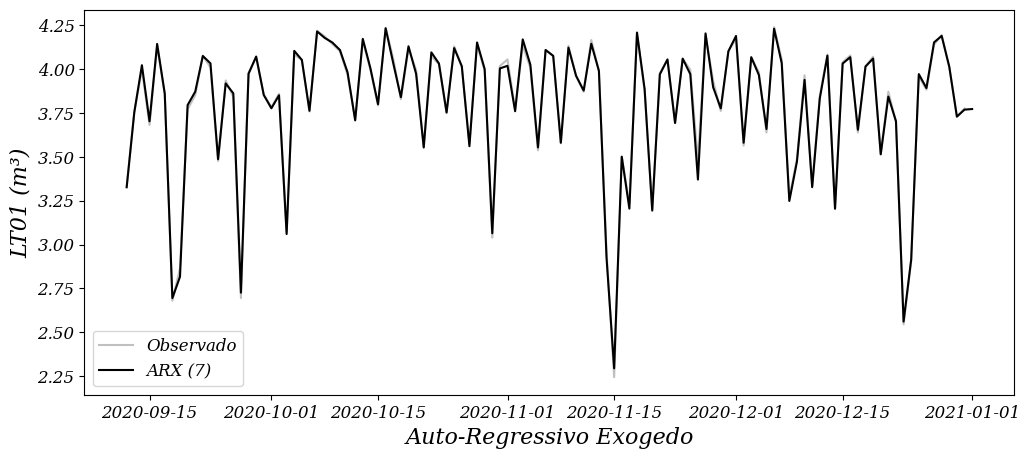

In [34]:
model_trn = ARIMA(endog_trn, exog_trn, order = (p1,0,0))
res_trn = model_trn.fit()

model_tst = ARIMA(endog_tst, exog_tst, order = (p1,0,0))
res_tst = model_tst.fit()

model_vld = ARIMA(endog_vld, exog_vld, order = (p1,0,0))
res_vld = model_vld.fit()

model = ARIMA(endog, exog, order = (p1,0,0))
res = model.fit()

### Previsão

arx_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv, exog = exog_trn[len(trn)-pv-1:])
arx_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv, exog = exog_vld[len(vld)-pv-1:])
arx_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv, exog = exog_tst[len(tst)-pv-1:])
arx = res.predict(start = -len(df), end = len(df)+pv, exog = exog[len(df)-pv-1:])

### Erros AR

mape_ARX_trn = mean_absolute_percentage_error(endog_trn, arx_trn[pv+1:])*100
mape_ARX_vld = mean_absolute_percentage_error(endog_vld, arx_vld[pv+1:])*100
mape_ARX_tst = mean_absolute_percentage_error(endog_tst, arx_tst[pv+1:])*100
ARX_mape = mean_absolute_percentage_error(endog, arx[pv+1:])*100

mae_ARX_trn = mean_absolute_error(endog_trn, arx_trn[pv+1:])*100
mae_ARX_vld = mean_absolute_error(endog_vld, arx_vld[pv+1:])*100
mae_ARX_tst = mean_absolute_error(endog_tst, arx_tst[pv+1:])*100
ARX_mae = mean_absolute_error(endog, arx[pv+1:])*100

rmse_ARX_trn = mean_squared_error(endog_trn, arx_trn[pv+1:], squared = False)*100
rmse_ARX_vld = mean_squared_error(endog_vld, arx_vld[pv+1:], squared = False)*100
rmse_ARX_tst = mean_squared_error(endog_tst, arx_tst[pv+1:], squared = False)*100
ARX_rmse = mean_squared_error(endog, arx[pv+1:])*100


print(f"ARX ({p1}) MAPE Error: {mape_ARX_trn:2.3f} Train")
print(f"ARX ({p1}) MAPE Error: {mape_ARX_vld:2.3f} Validation")
print(f"ARX ({p1}) MAPE Error: {mape_ARX_tst:2.3f} Test")
print(f"ARX ({p1}) MAPE Error: {ARX_mape:2.3f} ")

print(f"ARX ({p1}) MAE Error: {mae_ARX_trn:2.3f} Train")
print(f"ARX ({p1}) MAE Error: {mae_ARX_vld:2.3f} Validation")
print(f"ARX ({p1}) MAE Error: {mae_ARX_tst:2.3f} Test")
print(f"ARX ({p1}) MAE Error: {ARX_mae:2.3f} ")

print(f"ARX ({p1}) RMSE Error: {rmse_ARX_trn:2.3f} Train")
print(f"ARX ({p1}) RMSE Error: {rmse_ARX_vld:2.3f} Validation")
print(f"ARX ({p1}) RMSE Error: {rmse_ARX_tst:2.3f} Test")
print(f"ARX ({p1}) RMSE Error: {ARX_rmse:2.3f} ")

### Plotagem das previsão



# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arx_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel( 'Auto-Regressivo Exogedo', fontsize = 16)
plt.legend(['Observado', f"ARX ({p1})"])
plt.savefig(f'{pv}-ARX.pdf', dpi=500)
plt.show()


# Lag Ljung Box

In [35]:
lag = [10]
lag

[10]

In [36]:

lj_arx_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arx_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arx_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arx_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)


## Auto-Regressivo (AR)


AR (7) MAPE Error: 5.822 Train
AR (7) MAPE Error: 8.227 Validation
AR (7) MAPE Error: 9.186 Test
AR (7) MAPE Error: 6.470 
AR (7) MAE Error: 18.249 Train
AR (7) MAE Error: 29.793 Validation
AR (7) MAE Error: 32.716 Test
AR (7) MAE Error: 21.330 
AR (7) RMSE Error: 23.363 Train
AR (7) RMSE Error: 36.153 Validation
AR (7) RMSE Error: 38.598 Test
AR (7) RMSE Error: 6.935 


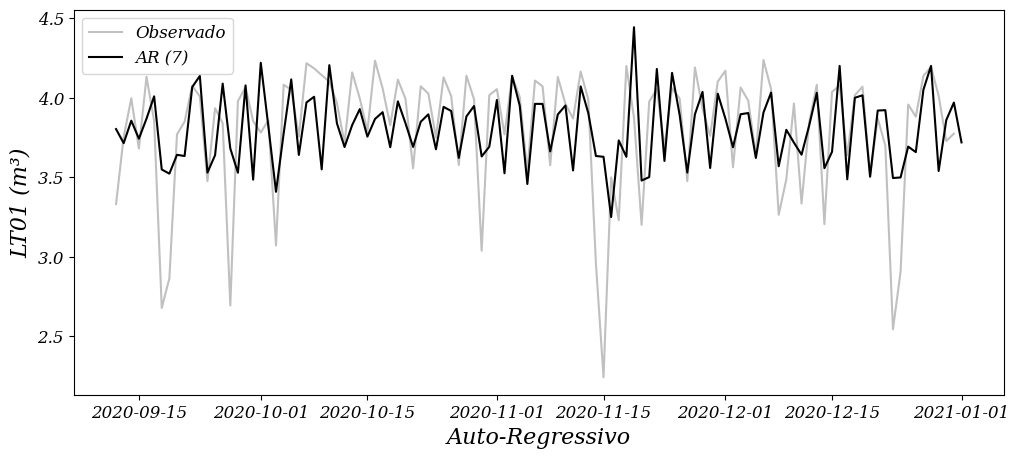

In [37]:
model_trn = ARIMA(endog_trn, order = (p1,0,0))
res_trn = model_trn.fit()

model_tst = ARIMA(endog_tst, order = (p1,0,0))
res_tst = model_tst.fit()

model_vld = ARIMA(endog_vld, order = (p1,0,0))
res_vld = model_vld.fit()

model = ARIMA(endog, order = (p1,0,0))
res = model.fit()

### Previsão

ar_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
ar_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
ar_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
ar = res.predict(start = -len(df), end = len(df)+pv)

### Erros AR

mape_AR_trn = mean_absolute_percentage_error(endog_trn, ar_trn[pv+1:])*100
mape_AR_vld = mean_absolute_percentage_error(endog_vld, ar_vld[pv+1:])*100
mape_AR_tst = mean_absolute_percentage_error(endog_tst, ar_tst[pv+1:])*100
AR_mape = mean_absolute_percentage_error(endog, ar[pv+1:])*100

mae_AR_trn = mean_absolute_error(endog_trn, ar_trn[pv+1:])*100
mae_AR_vld = mean_absolute_error(endog_vld, ar_vld[pv+1:])*100
mae_AR_tst = mean_absolute_error(endog_tst, ar_tst[pv+1:])*100
AR_mae = mean_absolute_error(endog, ar[pv+1:])*100

rmse_AR_trn = mean_squared_error(endog_trn, ar_trn[pv+1:], squared = False)*100
rmse_AR_vld = mean_squared_error(endog_vld, ar_vld[pv+1:], squared = False)*100
rmse_AR_tst = mean_squared_error(endog_tst, ar_tst[pv+1:], squared = False)*100
AR_rmse = mean_squared_error(endog, ar[pv+1:])*100

print(f"AR ({p1}) MAPE Error: {mape_AR_trn:2.3f} Train")
print(f"AR ({p1}) MAPE Error: {mape_AR_vld:2.3f} Validation")
print(f"AR ({p1}) MAPE Error: {mape_AR_tst:2.3f} Test")
print(f"AR ({p1}) MAPE Error: {AR_mape:2.3f} ")

print(f"AR ({p1}) MAE Error: {mae_AR_trn:2.3f} Train")
print(f"AR ({p1}) MAE Error: {mae_AR_vld:2.3f} Validation")
print(f"AR ({p1}) MAE Error: {mae_AR_tst:2.3f} Test")
print(f"AR ({p1}) MAE Error: {AR_mae:2.3f} ")

print(f"AR ({p1}) RMSE Error: {rmse_AR_trn:2.3f} Train")
print(f"AR ({p1}) RMSE Error: {rmse_AR_vld:2.3f} Validation")
print(f"AR ({p1}) RMSE Error: {rmse_AR_tst:2.3f} Test")
print(f"AR ({p1}) RMSE Error: {AR_rmse:2.3f} ")

### Plotagem das previsão



# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(ar_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel( 'Auto-Regressivo', fontsize = 16)
plt.legend(['Observado', f"AR ({p1})"])
plt.savefig(f'{pv}-AR.pdf', dpi=500)
plt.show()


In [38]:
lj_ar_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_ar_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_ar_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_ar_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## Médias Móveis (MA)


MA (7) MAPE Error: 5.640 Train
MA (7) MAPE Error: 8.551 Validation
MA (7) MAPE Error: 7.261 Test
MA (7) MAPE Error: 7.231 
MA (7) MAE Error: 17.558 Train
MA (7) MAE Error: 30.940 Validation
MA (7) MAE Error: 25.549 Test
MA (7) MAE Error: 23.488 
MA (7) RMSE Error: 22.383 Train
MA (7) RMSE Error: 36.987 Validation
MA (7) RMSE Error: 32.557 Test
MA (7) RMSE Error: 30.282 Test


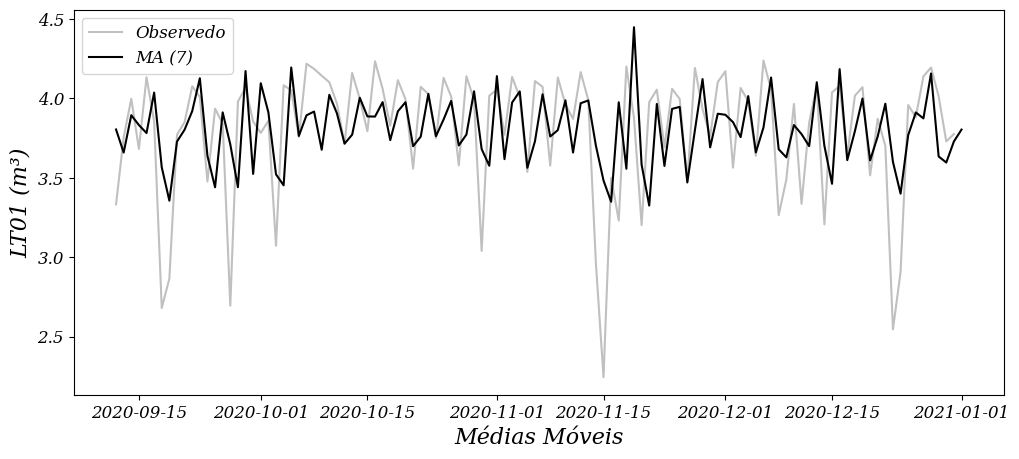

In [39]:

model_trn = ARIMA(endog_trn,order=(0,0,q1))
res_trn = model_trn.fit()

model_vld = ARIMA(endog_vld,order=(0,0,q1))
res_vld = model_vld.fit()

model_tst = ARIMA(endog_tst,order=(0,0,q1))
res_tst = model_tst.fit()

model = ARIMA(endog,order=(0,0,1))
res = model.fit()

### Previsão

ma_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
ma_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
ma_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
MA = res.predict(start = -len(df), end = len(df)+pv)

### Erros MA

mape_MA_trn = mean_absolute_percentage_error(endog_trn, ma_trn[pv+1:])*100
mape_MA_vld = mean_absolute_percentage_error(endog_vld, ma_vld[pv+1:])*100
mape_MA_tst = mean_absolute_percentage_error(endog_tst, ma_tst[pv+1:])*100
MA_mape = mean_absolute_percentage_error(endog, MA[pv+1:])*100

mae_MA_trn = mean_absolute_error(endog_trn, ma_trn[pv+1:])*100
mae_MA_vld = mean_absolute_error(endog_vld, ma_vld[pv+1:])*100
mae_MA_tst = mean_absolute_error(endog_tst, ma_tst[pv+1:])*100
MA_mae = mean_absolute_error(endog, MA[pv+1:])*100

rmse_MA_trn = mean_squared_error(endog_trn, ma_trn[pv+1:], squared = False)*100
rmse_MA_vld = mean_squared_error(endog_vld, ma_vld[pv+1:], squared = False)*100
rmse_MA_tst = mean_squared_error(endog_tst, ma_tst[pv+1:], squared = False)*100
MA_rmse = mean_squared_error(endog, MA[pv+1:], squared = False)*100

print(f"MA ({q1}) MAPE Error: {mape_MA_trn:2.3f} Train")
print(f"MA ({q1}) MAPE Error: {mape_MA_vld:2.3f} Validation")
print(f"MA ({q1}) MAPE Error: {mape_MA_tst:2.3f} Test")
print(f"MA ({q1}) MAPE Error: {MA_mape:2.3f} ")

print(f"MA ({q1}) MAE Error: {mae_MA_trn:2.3f} Train")
print(f"MA ({q1}) MAE Error: {mae_MA_vld:2.3f} Validation")
print(f"MA ({q1}) MAE Error: {mae_MA_tst:2.3f} Test")
print(f"MA ({q1}) MAE Error: {MA_mae:2.3f} ")

print(f"MA ({q1}) RMSE Error: {rmse_MA_trn:2.3f} Train")
print(f"MA ({q1}) RMSE Error: {rmse_MA_vld:2.3f} Validation")
print(f"MA ({q1}) RMSE Error: {rmse_MA_tst:2.3f} Test")
print(f"MA ({q1}) RMSE Error: {MA_rmse:2.3f} Test")


### Plotagem das previsão


# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(ma_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('Médias Móveis', fontsize = 16)
plt.legend(['Observedo', f"MA ({q1})"])
plt.savefig(f"{pv}-MA.pdf", dpi=500)

plt.show()


In [40]:

lj_ma_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_ma_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_ma_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_ma_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)


## ARMA


c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

ARMA (7, 7) MAPE Error: 6.038 Train
ARMA (7, 7) MAPE Error: 8.496 Validation
ARMA (7, 7) MAPE Error: 9.812 Test
ARMA (7, 7) MAPE Error: 6.751 
ARMA (7, 7) MAE Error: 19.227 Train
ARMA (7, 7) MAE Error: 30.688 Validation
ARMA (7, 7) MAE Error: 35.046 Test
ARMA (7, 7) MAE Error: 22.622
ARMA (7, 7) RMSE Error: 25.046 Train
ARMA (7, 7) RMSE Error: 37.427 Validation
ARMA (7, 7) RMSE Error: 42.347 Test
ARMA (7, 7) RMSE Error: 27.917 Test


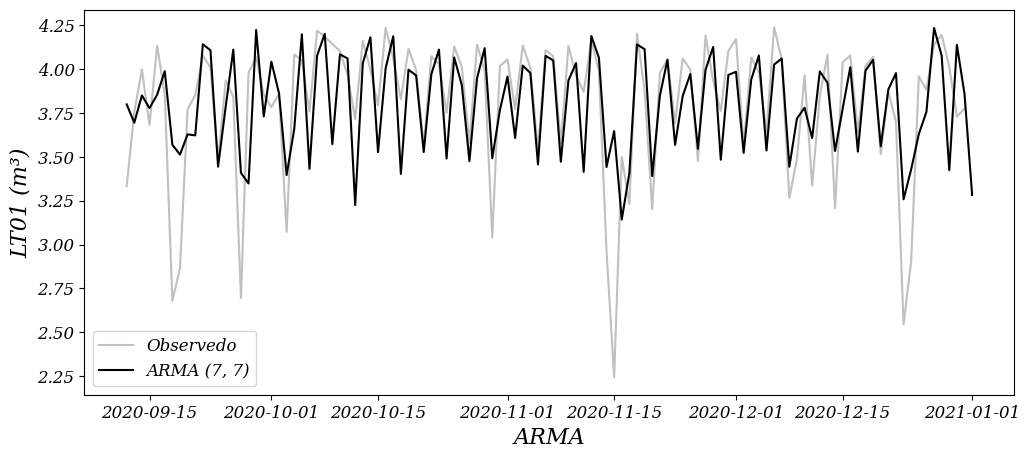

In [41]:

model_trn = ARIMA(endog_trn,order=(p1,0,q1))
res_trn = model_trn.fit()

model_vld = ARIMA(endog_vld,order=(p1,0,q1))
res_vld = model_vld.fit()

model_tst = ARIMA(endog_tst,order=(p1,0,q1))
res_tst = model_tst.fit()

model = ARIMA(endog,order=(p1,0,q1))
res = model.fit()

arma_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
arma_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
arma_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
arma = res.predict(start = -len(df), end = len(df)+pv)


### Erros ARMA



mape_ARMA_trn = mean_absolute_percentage_error(endog_trn, arma_trn[pv+1:])*100
mape_ARMA_vld = mean_absolute_percentage_error(endog_vld, arma_vld[pv+1:])*100
mape_ARMA_tst = mean_absolute_percentage_error(endog_tst, arma_tst[pv+1:])*100
ARMA_mape = mean_absolute_percentage_error(endog, arma[pv+1:])*100

mae_ARMA_trn = mean_absolute_error(endog_trn, arma_trn[pv+1:])*100
mae_ARMA_vld = mean_absolute_error(endog_vld, arma_vld[pv+1:])*100
mae_ARMA_tst = mean_absolute_error(endog_tst, arma_tst[pv+1:])*100
ARMA_mae = mean_absolute_error(endog, arma[pv+1:])*100

rmse_ARMA_trn = mean_squared_error(endog_trn, arma_trn[pv+1:], squared = False)*100
rmse_ARMA_vld = mean_squared_error(endog_vld, arma_vld[pv+1:], squared = False)*100
rmse_ARMA_tst = mean_squared_error(endog_tst, arma_tst[pv+1:], squared = False)*100
ARMA_rmse = mean_squared_error(endog, arma[pv+1:], squared = False)*100


print(f"ARMA {p1,q1} MAPE Error: {mape_ARMA_trn:2.3f} Train")
print(f"ARMA {p1,q1} MAPE Error: {mape_ARMA_vld:2.3f} Validation")
print(f"ARMA {p1,q1} MAPE Error: {mape_ARMA_tst:2.3f} Test")
print(f"ARMA {p1,q1} MAPE Error: {ARMA_mape:2.3f} ")

print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_trn:2.3f} Train")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_vld:2.3f} Validation")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_tst:2.3f} Test")
print(f"ARMA {p1,q1} MAE Error: {ARMA_mae:2.3f}")

print(f"ARMA {p1,q1} RMSE Error: {rmse_ARMA_trn:2.3f} Train")
print(f"ARMA {p1,q1} RMSE Error: {rmse_ARMA_vld:2.3f} Validation")
print(f"ARMA {p1,q1} RMSE Error: {rmse_ARMA_tst:2.3f} Test")
print(f"ARMA {p1,q1} RMSE Error: {ARMA_rmse:2.3f} Test")

### Plotagem das previsão


# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arma_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('ARMA', fontsize = 16)
plt.legend(['Observedo', f"ARMA {p1,q1}"])
plt.savefig(f"{pv}-ARMA.pdf", dpi=300)
plt.show()


In [42]:

lj_arma_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arma_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arma_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arma_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## ARIMA

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

ARIMA (7, 1, 7) MAPE Error: 6.054 Train
ARIMA (7, 1, 7) MAPE Error: 8.109 Validation
ARIMA (7, 1, 7) MAPE Error: 9.285 Test
ARIMA (7, 1, 7) MAPE Error: 7.100
ARIMA (7, 1, 7) MAE Error: 19.459 Train
ARIMA (7, 1, 7) MAE Error: 29.689 Validation
ARIMA (7, 1, 7) MAE Error: 33.307 Test
ARIMA (7, 1, 7) MAE Error: 23.807
ARIMA (7, 1, 7) RMSE Error: 25.262 Train
ARIMA (7, 1, 7) RMSE Error: 37.600 Validation
ARIMA (7, 1, 7) RMSE Error: 40.436 Test
ARIMA (7, 1, 7) RMSE Error: 29.410


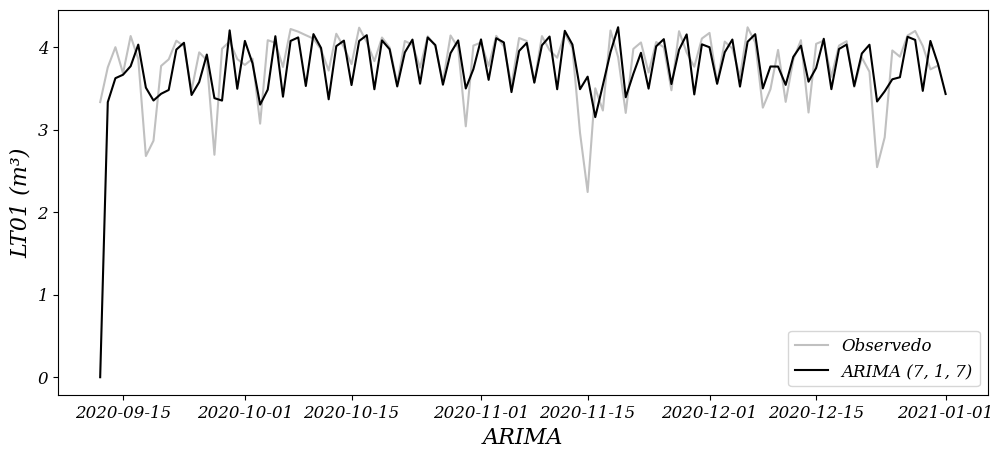

In [43]:

model_trn = ARIMA(endog_trn,
                        order=(p1,d1,q1))
res_trn = model_trn.fit()

model_vld = ARIMA(endog_vld,
                        order=(p1,d1,q1))
res_vld = model_vld.fit()

model_tst = ARIMA(endog_tst,
                        order=(p1,d1,q1))
res_tst = model_tst.fit()

model_df = ARIMA(endog,
                        order=(p1,d1,q1))
res_df = model_df.fit()

arima_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
arima_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
arima_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
arima = res_df.predict(start = -len(df), end = len(df)+pv)

### Erros ARIMA



mape_ARIMA_trn = mean_absolute_percentage_error(endog_trn, arima_trn[pv+1:])*100
mape_ARIMA_vld = mean_absolute_percentage_error(endog_vld, arima_vld[pv+1:])*100
mape_ARIMA_tst = mean_absolute_percentage_error(endog_tst, arima_tst[pv+1:])*100
ARIMA_mape = mean_absolute_percentage_error(endog, arima[pv+1:])*100

mae_ARIMA_trn = mean_absolute_error(endog_trn, arima_trn[pv+1:])*100
mae_ARIMA_vld = mean_absolute_error(endog_vld, arima_vld[pv+1:])*100
mae_ARIMA_tst = mean_absolute_error(endog_tst, arima_tst[pv+1:])*100
ARIMA_mae = mean_absolute_error(endog, arima[pv+1:])*100

rmse_ARIMA_trn = mean_squared_error(endog_trn, arima_trn[pv+1:], squared = False)*100
rmse_ARIMA_vld = mean_squared_error(endog_vld, arima_vld[pv+1:], squared = False)*100
rmse_ARIMA_tst = mean_squared_error(endog_tst, arima_tst[pv+1:], squared = False)*100
ARIMA_rmse = mean_squared_error(endog, arima[pv+1:], squared = False)*100

print(f"ARIMA {p1,d1,q1} MAPE Error: {mape_ARIMA_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} MAPE Error: {mape_ARIMA_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} MAPE Error: {mape_ARIMA_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} MAPE Error: {ARIMA_mape:2.3f}")

print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} MAE Error: {ARIMA_mae:2.3f}")

print(f"ARIMA {p1,d1,q1} RMSE Error: {rmse_ARIMA_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} RMSE Error: {rmse_ARIMA_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} RMSE Error: {rmse_ARIMA_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} RMSE Error: {ARIMA_rmse:2.3f}")


### Plotagem das previsão

# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arima_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('ARIMA', fontsize = 16)
plt.legend(['Observedo', f"ARIMA {p1,d1,q1}"])
plt.savefig(f"{pv}-ARIMA.pdf", dpi=500)
plt.show()


In [44]:

lj_arima_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arima_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arima_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arima_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## SARIMA


c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

SARIMA (7, 1, 7) (2, 1, 0, 12) MAPE Error: 7.418 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) MAPE Error: 8.963 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) MAPE Error: 9.657 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) MAPE Error: 8.243
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 24.203 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 33.360 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 35.244 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 28.556
SARIMA (7, 1, 7) (2, 1, 0, 12) RMSE Error: 33.863 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) RMSE Error: 51.691 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) RMSE Error: 45.159 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) RMSE Error: 36.789


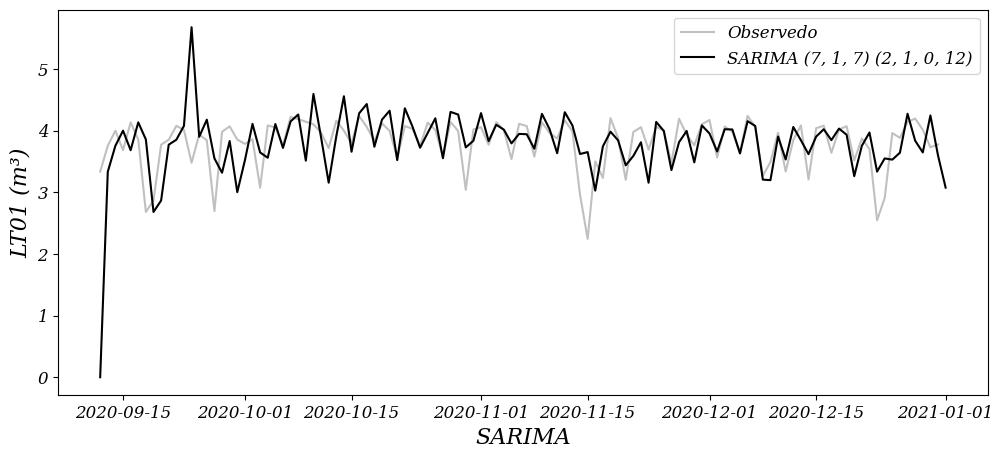

In [45]:
model_trn = sr(endog_trn,order=(p1,d1,q1),
                 seasonal_order = (P1,D1,Q1,M1),
                 simple_differencing=False)
res_trn = model_trn.fit(dis=False)

model_vld = sr(endog_vld,order=(p1,d1,q1),
                 seasonal_order = (P1,D1,Q1,M1),
                 simple_differencing=False)
res_vld = model_vld.fit(dis=False)

model_tst = sr(endog_tst,order=(p1,d1,q1),
                 seasonal_order = (P1,D1,Q1,M1),
                 simple_differencing=False)
res_tst = model_tst.fit(dis=False)

model_df = sr(endog,order=(p1,d1,q1),
                seasonal_order = (P1,D1,Q1,M1),
                simple_differencing=False)
res_df = model_df.fit(dis=False)

### Erro SARIMA

sarima_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
sarima_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
sarima_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
sarima = res_df.predict(start = -len(df), end = len(df)+pv)

mape_SARIMA_trn = mean_absolute_percentage_error(endog_trn, sarima_trn[pv+1:])*100
mape_SARIMA_vld = mean_absolute_percentage_error(endog_vld, sarima_vld[pv+1:])*100
mape_SARIMA_tst = mean_absolute_percentage_error(endog_tst, sarima_tst[pv+1:])*100
SARIMA_mape = mean_absolute_percentage_error(endog, sarima[pv+1:])*100

mae_SARIMA_trn = mean_absolute_error(endog_trn, sarima_trn[pv+1:])*100
mae_SARIMA_vld = mean_absolute_error(endog_vld, sarima_vld[pv+1:])*100
mae_SARIMA_tst = mean_absolute_error(endog_tst, sarima_tst[pv+1:])*100
SARIMA_mae = mean_absolute_error(endog, sarima[pv+1:])*100

rmse_SARIMA_trn = mean_squared_error(endog_trn, sarima_trn[pv+1:], squared = False)*100
rmse_SARIMA_vld = mean_squared_error(endog_vld, sarima_vld[pv+1:], squared = False)*100
rmse_SARIMA_tst = mean_squared_error(endog_tst, sarima_tst[pv+1:], squared = False)*100
SARIMA_rmse = mean_squared_error(endog, sarima[pv+1:], squared = False)*100

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAPE Error: {mape_SARIMA_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAPE Error: {mape_SARIMA_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAPE Error: {mape_SARIMA_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAPE Error: {SARIMA_mape:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {SARIMA_mae:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RMSE Error: {rmse_SARIMA_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RMSE Error: {rmse_SARIMA_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RMSE Error: {rmse_SARIMA_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RMSE Error: {SARIMA_rmse:2.3f}")

### Plotagem da previsão

# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(sarima_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('SARIMA', fontsize = 16)
plt.legend(['Observedo', f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1}"])
plt.savefig(f"{pv}-SARIMA.pdf", dpi=500)
plt.show()


ADF Statistic: -2.9786992635110012
p-value: 0.03693207330316799


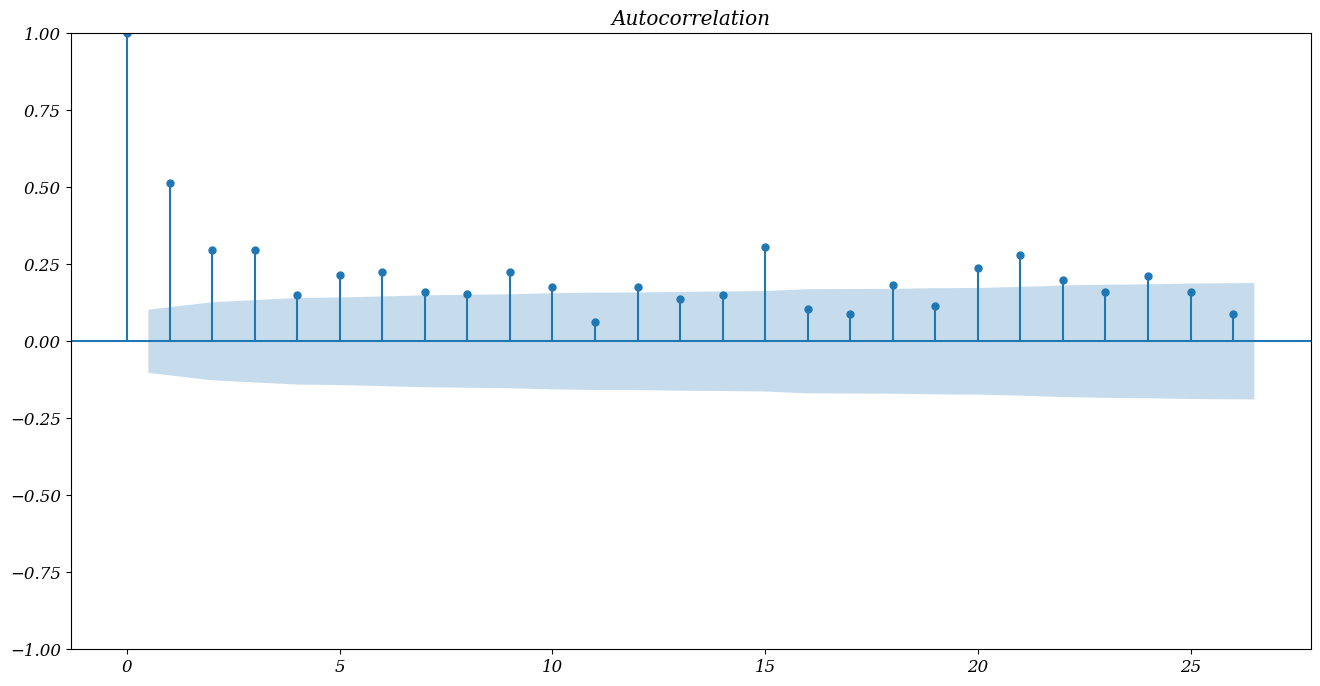

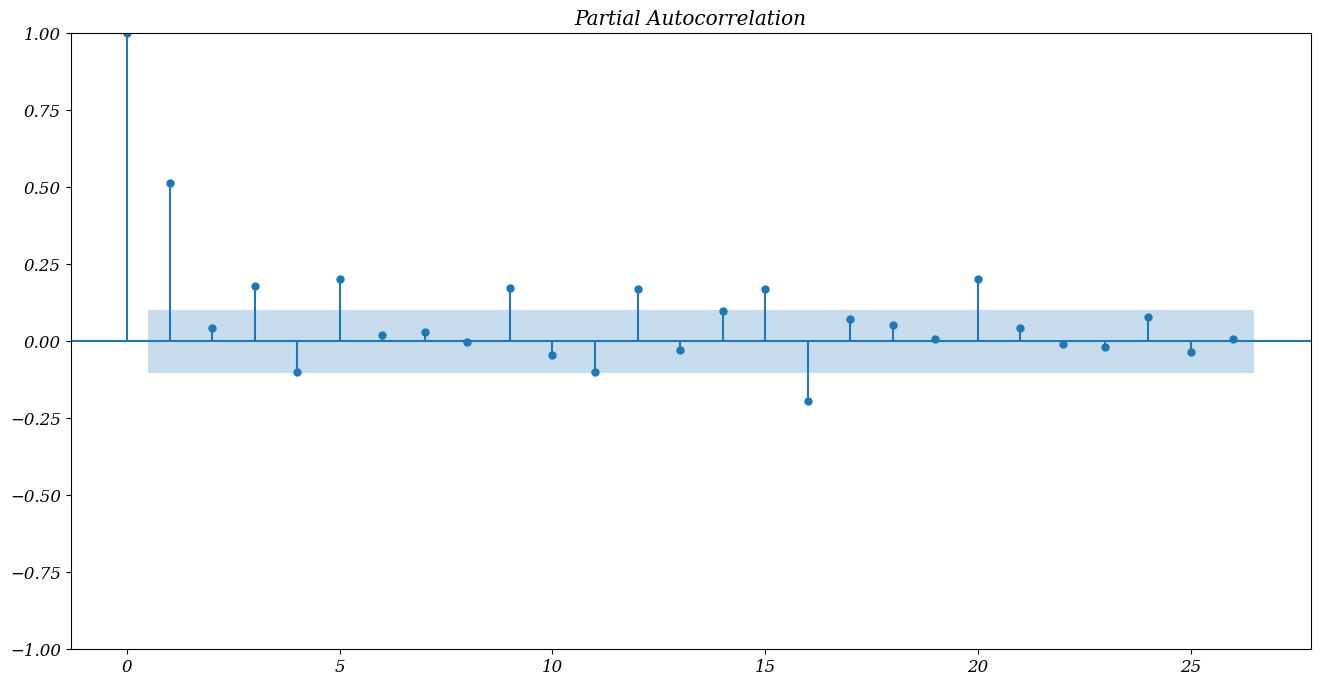

In [145]:

ad_fuller_result = adfuller(endog[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


plot_acf(endog[1:]);
plt.savefig(f"acf.pdf", dpi=500)
plot_pacf(endog[1:]);
plt.savefig(f"pacf.pdf", dpi=500)


In [47]:

lj_sarima_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_sarima_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_sarima_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_sarima_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## ARIMAX

ARIMAX (7, 1, 7)  MAPE Error: 10.161 Train
ARIMAX (7, 1, 7)  MAPE Error: 10.213 Validation
ARIMAX (7, 1, 7)  MAPE Error: 11.018 Test
ARIMAX (7, 1, 7) MAPE Error: 10.480
ARIMAX (7, 1, 7)  MAE Error: 33.005 Train
ARIMAX (7, 1, 7)  MAE Error: 37.457 Validation
ARIMAX (7, 1, 7)  MAE Error: 39.149 Test
ARIMAX (7, 1, 7) MAE Error: 35.692
ARIMAX (7, 1, 7)  RMSE Error: 45.471 Train
ARIMAX (7, 1, 7)  RMSE Error: 48.153 Validation
ARIMAX (7, 1, 7)  RMSE Error: 50.368 Test
ARIMAX (7, 1, 7) RMSE Error: 47.492


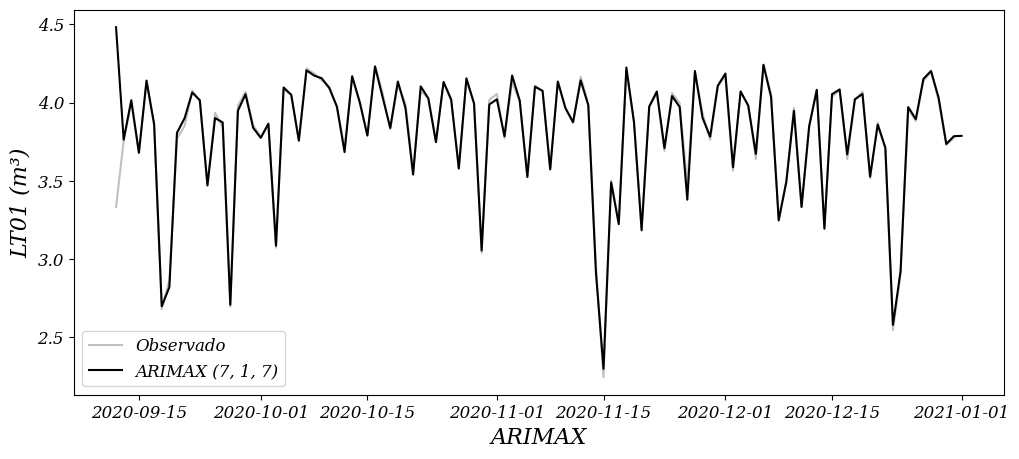

In [48]:

best_model_tst = ARIMA(endog_tst, 
                     exog_tst, 
                     order=(p1,d1,q1))


res_tst = best_model_tst.fit()
### Validação



best_model_vld = ARIMA(endog_vld, 
                     exog_vld, 
                     order=(p1,d1,q1))

res_vld = best_model_vld.fit()

### Treino

best_model_trn = ARIMA(endog_trn, 
                     exog_trn, 
                     order=(p1,d1,q1))

res_trn = best_model_trn.fit()

### ARIMAX

best_model = ARIMA(endog, 
                     exog, 
                     order=(p1,d1,q1))

res = best_model.fit()



### Prevendo ARIMAX

arimax_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv, exog = exog_trn[len(trn)-pv-1:])
arimax_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv, exog = exog_vld[len(vld)-pv-1:])
arimax_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv, exog = exog_tst[len(tst)-pv-1:])
arimax = res.predict(start = -len(df), end = len(df)+pv, exog = exog[len(df)-pv-1:])


### Erros ARIMAX

mape_arimax_trn = mean_absolute_percentage_error(endog_trn, arimax_trn[pv+1:])*100
mape_arimax_vld = mean_absolute_percentage_error(endog_vld, arimax_vld[pv+1:])*100
mape_arimax_tst = mean_absolute_percentage_error(endog_tst, arimax_tst[pv+1:])*100
arimax_mape = mean_absolute_percentage_error(endog, arimax[pv+1:])*100

mae_arimax_trn = mean_absolute_error(endog_trn, arimax_trn[pv+1:])*100
mae_arimax_vld = mean_absolute_error(endog_vld, arimax_vld[pv+1:])*100
mae_arimax_tst = mean_absolute_error(endog_tst, arimax_tst[pv+1:])*100
arimax_mae = mean_absolute_error(endog, arimax[pv+1:])*100

rmse_arimax_trn = mean_squared_error(endog_trn, arimax_trn[pv+1:], squared = False)*100
rmse_arimax_vld = mean_squared_error(endog_vld, arimax_vld[pv+1:], squared = False)*100
rmse_arimax_tst = mean_squared_error(endog_tst, arimax_tst[pv+1:], squared = False)*100
arimax_rmse = mean_squared_error(endog, arimax[pv+1:], squared = False)*100

print(f"ARIMAX {p1,d1,q1}  MAPE Error: {mape_arimax_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  MAPE Error: {mape_arimax_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  MAPE Error: {mape_arimax_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1} MAPE Error: {arimax_mape:2.3f}")

print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1} MAE Error: {arimax_mae:2.3f}")

print(f"ARIMAX {p1,d1,q1}  RMSE Error: {rmse_arimax_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  RMSE Error: {rmse_arimax_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  RMSE Error: {rmse_arimax_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1} RMSE Error: {arimax_rmse:2.3f}")

# Visualiza previsão
# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arimax_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel(f'ARIMAX', fontsize = 16)
plt.legend(['Observado', f"ARIMAX {p1,d1,q1}"])
plt.savefig(f"{pv}-ARIMAX.pdf", dpi=500)
plt.show()

In [49]:

lj_arimax_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arimax_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arimax_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arimax_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## SARIMAX

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAPE Erro: 10.230 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAPE Erro: 10.464 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAPE Erro: 11.116 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) MAPE Erro: 10.541
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 33.272 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 38.586 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 39.541 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) MAE Erro: 35.921
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RMSE Erro: 45.066 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RMSE Erro: 50.982 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RMSE Erro: 51.203 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) RMSE Erro: 47.312


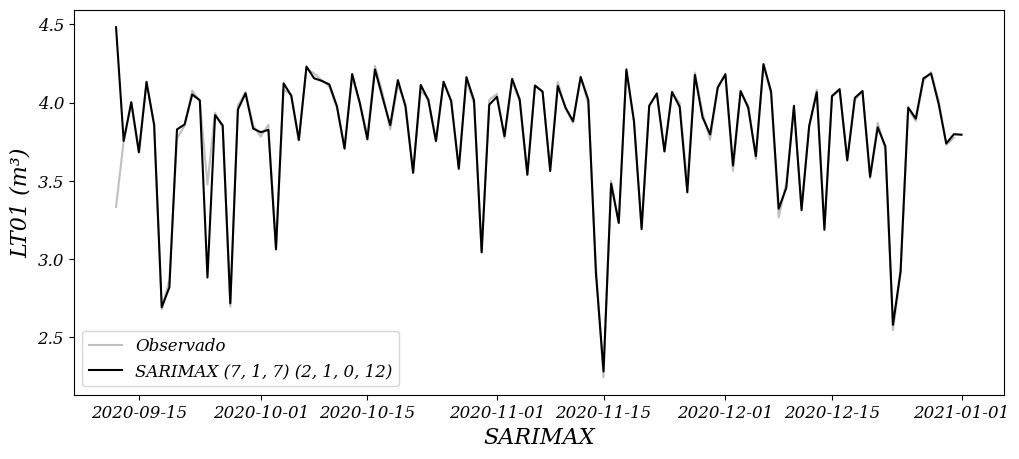

In [50]:

best_model_tst = sr(endog_tst, 
                     exog_tst, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)


res_tst = best_model_tst.fit(dis=False)
### Validação



best_model_vld = sr(endog_vld, 
                     exog_vld, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)

res_vld = best_model_vld.fit(dis=False)

### Treino

best_model_trn = sr(endog_trn, 
                     exog_trn, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)

res_trn = best_model_trn.fit(dis=False)

### DADOS COMPLETO

best_model = sr(endog, 
                     exog, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)

res = best_model.fit(dis=False)

### Prevendo SARIMAX

sarimax_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv, exog = exog_trn[len(trn)-pv-1:])

sarimax_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv, exog = exog_vld[len(vld)-pv-1:])

sarimax_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv, exog = exog_tst[len(tst)-pv-1:])

sarimax = res.predict(start = -len(df), end = len(df)+pv, exog = exog[len(df)-pv-1:])


### Erros SARIMAX

mape_sarimax_trn = mean_absolute_percentage_error(endog_trn, sarimax_trn[pv+1:])*100
mape_sarimax_vld = mean_absolute_percentage_error(endog_vld, sarimax_vld[pv+1:])*100
mape_sarimax_tst = mean_absolute_percentage_error(endog_tst, sarimax_tst[pv+1:])*100
sarimax_mape = mean_absolute_percentage_error(endog, sarimax[pv+1:])*100

mae_sarimax_trn = mean_absolute_error(endog_trn, sarimax_trn[pv+1:])*100
mae_sarimax_vld = mean_absolute_error(endog_vld, sarimax_vld[pv+1:])*100
mae_sarimax_tst = mean_absolute_error(endog_tst, sarimax_tst[pv+1:])*100
sarimax_mae = mean_absolute_error(endog, sarimax[pv+1:])*100

rmse_sarimax_trn = mean_squared_error(endog_trn, sarimax_trn[pv+1:], squared = False)*100
rmse_sarimax_vld = mean_squared_error(endog_vld, sarimax_vld[pv+1:], squared = False)*100
rmse_sarimax_tst = mean_squared_error(endog_tst, sarimax_tst[pv+1:], squared = False)*100
sarimax_rmse = mean_squared_error(endog, sarimax[pv+1:], squared = False)*100


print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAPE Erro: {mape_sarimax_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAPE Erro: {mape_sarimax_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAPE Erro: {mape_sarimax_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} MAPE Erro: {sarimax_mape:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} MAE Erro: {sarimax_mae:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RMSE Erro: {rmse_sarimax_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RMSE Erro: {rmse_sarimax_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RMSE Erro: {rmse_sarimax_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} RMSE Erro: {sarimax_rmse:2.3f}")


# Visualiza previsão

# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(sarimax_tst, 'black')
plt.ylabel(rt , fontsize = 16)
plt.xlabel(f'SARIMAX', fontsize = 16)
plt.legend(['Observado',f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
plt.savefig(f"{pv}-SARIMAX.pdf", dpi=500)
plt.show()

In [51]:

lj_sarimax_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_sarimax_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_sarimax_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_sarimax_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## Comparação dos modelos ARIMA

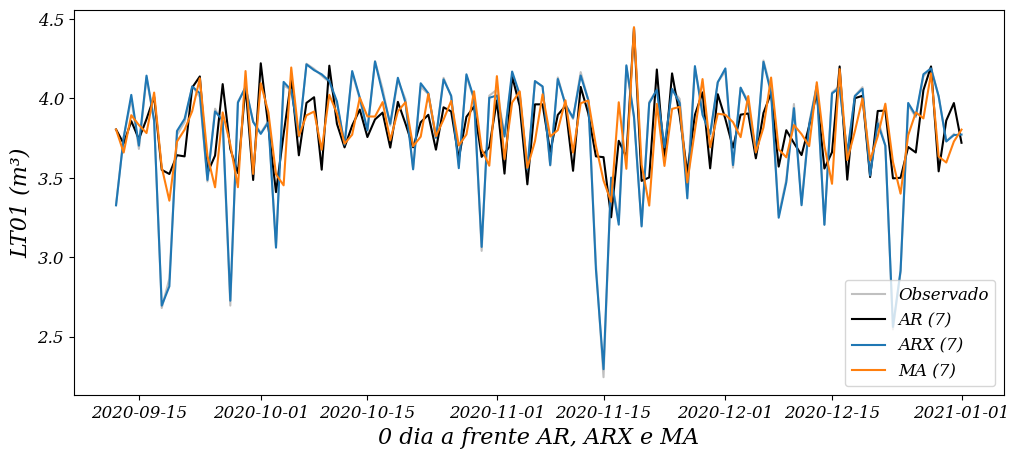

In [52]:
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(ar_tst, 'black')
plt.plot(arx_tst)
plt.plot(ma_tst)


plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl+' AR, ARX e MA', fontsize = 16)
plt.legend(['Observado',f'AR ({p1})',f'ARX ({p1})', f'MA ({q1})'])
plt.savefig(f"{pv}-AR-ARX-MA.pdf", dpi=500)
plt.show()

In [53]:
# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(list(endog_tst))
# plt.plot(list(ar_tst), 'black')
# plt.plot(list(arx_tst), 'red')
# plt.plot(list(ma_tst), 'yellow')


# plt.ylabel(rt , fontsize = 16)
# plt.xlabel(pvl+' AR, ARX e MA', fontsize = 16)
# plt.legend(['Observado',f'AR ({p1})',f'ARX ({p1})', f'MA {q1}'])
# plt.savefig(f"{pv}-AR-ARX-MA.png", dpi=300)
# plt.show()

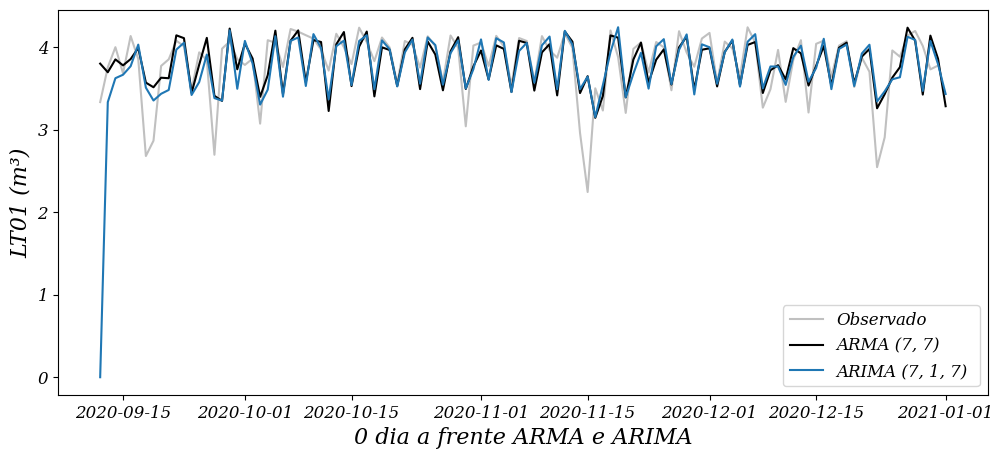

In [54]:


plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arma_tst, 'black')
plt.plot(arima_tst)
plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl+' ARMA e ARIMA', fontsize = 16)
plt.legend(['Observado',f'ARMA {p1,q1}',f'ARIMA {p1,d1,q1} '])
plt.savefig(f"{pv}-ARMA-ARIMA.pdf", dpi=500)
plt.show()


In [55]:


# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(list(endog_tst))
# plt.plot(list(arma_tst), 'black')
# plt.plot(list(arima_tst), 'red')
# plt.ylabel(rt , fontsize = 16)
# plt.xlabel(pvl+'ARMA e ARIMA', fontsize = 16)
# plt.legend(['Observado',f'ARMA {p1,q1}',f'ARIMA {p1,d1,q1} '])
# plt.savefig(f"{pv}-ARMA-ARIMA.png", dpi=300)
# plt.show()


In [56]:

# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(list(endog_tst))
# plt.plot(list(sarima_tst), 'black')
# plt.plot(list(sarimax_tst), 'red')
# plt.plot(list(arimax_tst), 'yellow')
# plt.ylabel(rt , fontsize = 16)
# plt.xlabel(pvl+' ARIMAX, SARIMA e SARIMAX', fontsize = 16)
# plt.legend(['Observado',f'ARIMAX{p1,d1,q1}',f'SARIMA {p1,d1,q1} {P1,D1,Q1,M1}',
# f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
# plt.savefig(f"{pv}-ARIMAX-SARIMA-SARIMAX.png", dpi=300)
# plt.show()

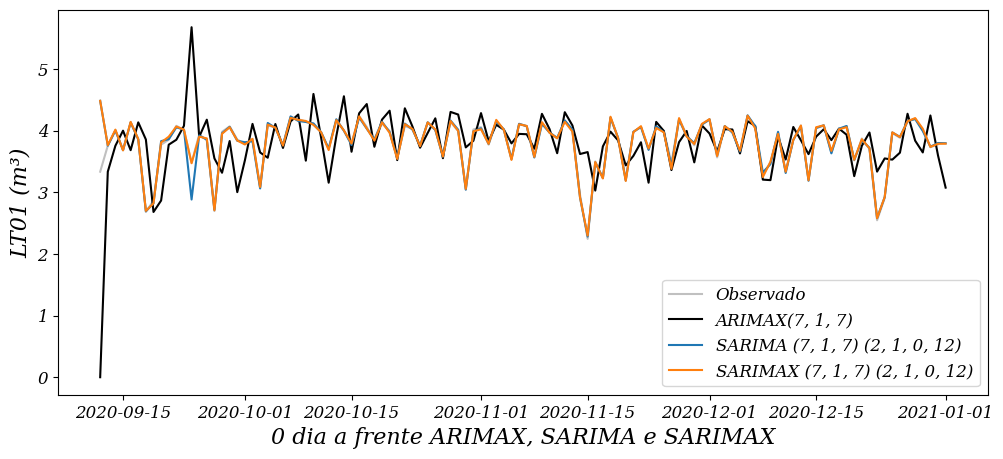

In [57]:

plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(sarima_tst, 'black')
plt.plot(sarimax_tst)
plt.plot(arimax_tst)
plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl+' ARIMAX, SARIMA e SARIMAX', fontsize = 16)
plt.legend(['Observado',f'ARIMAX{p1,d1,q1}',f'SARIMA {p1,d1,q1} {P1,D1,Q1,M1}',
f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
plt.savefig(f"{pv}-ARIMAX-SARIMA-SARIMAX.pdf", dpi=500)
plt.show()

## Regressão

[19:12:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[19:12:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[19:12:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[19:12:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_

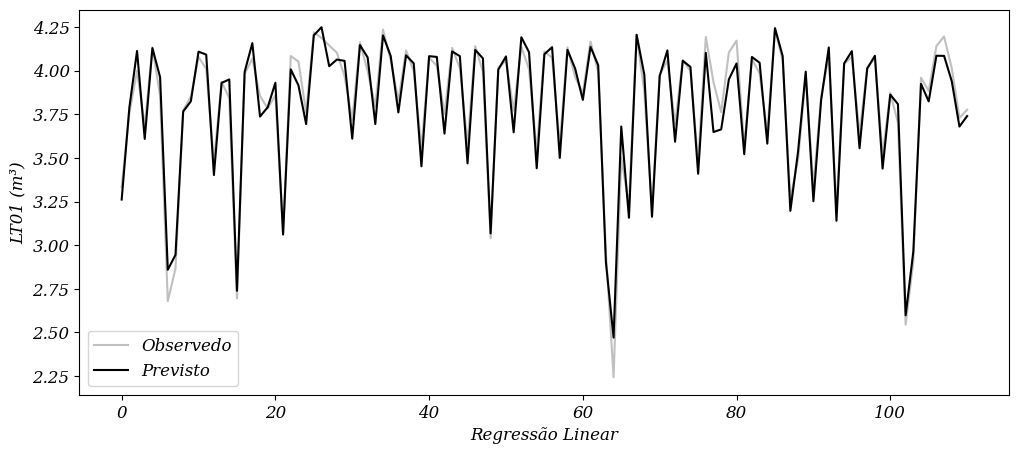

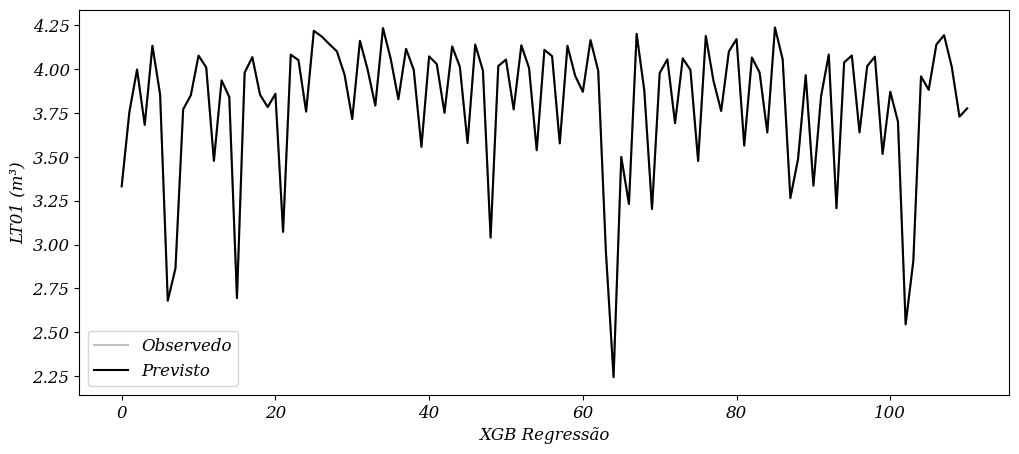

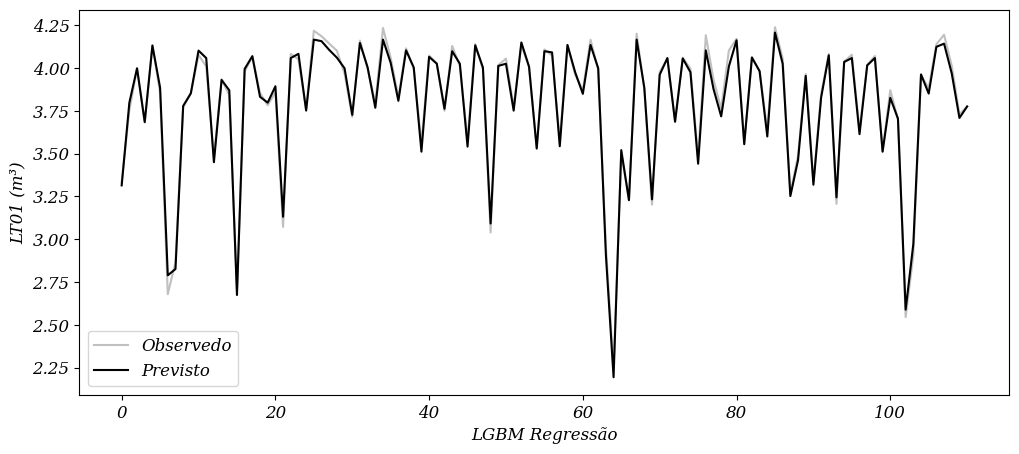

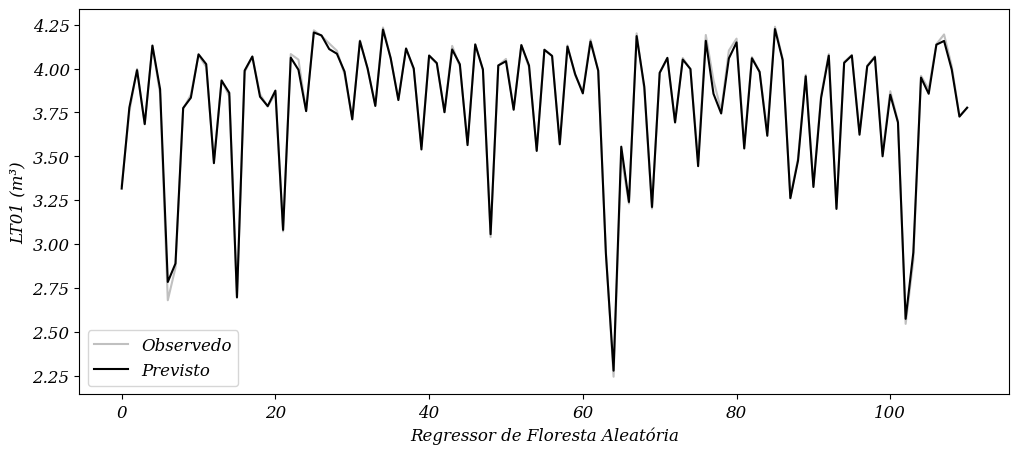

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

import math

endog_l_trn = trn[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_tst = tst[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_vld = vld[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l = df[['PRESSÃO DE SUCÇÃO - PT01']]


my_lm = LinearRegression()
lm_trn = my_lm.fit(X =endog_l_trn, y = endog_trn)
lm_vld = my_lm.fit(X =endog_l_vld, y = endog_vld)
lm_tst = my_lm.fit(X =endog_l_tst, y = endog_tst)
lm = my_lm.fit(X =endog_l, y = endog)
lr_trn = lm_trn.predict(endog_l_trn+pv)
lr_vld = lm_vld.predict(endog_l_vld+pv)
lr_tst = lm_tst.predict(endog_l_tst+pv)
lr = lm_tst.predict(endog_l+pv)

random.seed(0)

my_xgb = XGBRegressor(base_score=0.5, booster='gbtree', bootstrap=True, callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=14, max_features='log2', max_leaves=0,
             min_child_weight=1, min_samples_leaf=3, min_samples_split=2,
             monotone_constraints='()', n_estimators=800)

# my_xgb = XGBRegressor()

# my_xgb = BayesSearchCV(
#     XGBRegressor(){
#         'learning_rate': (10e-6, 1.0, 'log-uniform')
#         'max_depth': Integer(0, 50, 'uniform')
#         'n_estimators' : (10, 1000, 'log-uniform')},
#         n_iter=10, cv=3)
x_trn = my_xgb.fit(X = exog_trn, y = endog_trn)
x_tst = my_xgb.fit(X = exog_tst, y = endog_tst)
x_vld = my_xgb.fit(X = exog_vld, y = endog_vld)
x = my_xgb.fit(X = exog, y = endog)
xgb_trn = x_trn.predict(exog_trn+pv)
xgb_vld = x_vld.predict(exog_vld+pv)
xgb_tst = x_tst.predict(exog_tst+pv)
xgb = x.predict(exog+pv)

my_lgbm = LGBMRegressor(bootstrap=True, max_depth=2, max_features='auto',
              min_samples_leaf=2, min_samples_split=2)

# my_lgbm = LGBMRegressor(bootstrap=True, max_depth=14, max_features='log2',
#               min_samples_leaf=3, min_samples_split=2, n_estimators=800)

# my_lgbm = LGBMRegressor()
lb_trn = my_lgbm.fit(X = exog_trn, y = endog_trn)
lb_vld = my_lgbm.fit(X = exog_vld, y = endog_vld)
lb_tst = my_lgbm.fit(X = exog_tst, y = endog_tst)
lb = my_lgbm.fit(X = exog, y = endog)
lgbm_trn = lb_trn.predict(exog_trn+pv)
lgbm_vld = lb_vld.predict(exog_vld+pv)
lgbm_tst = lb_tst.predict(exog_tst+pv)
lgbm = lb.predict(exog+pv)

# my_rf = GridSearchCV(RandomForestRegressor(){
#         'max_features':[0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
#         'n_estimators': [10, 50, 100, 250, 500, 750, 1000]},
#         scoring = 'r2', n_jobs = -1)

# distributions = {'max_features': stats.norm(0.8, math.sqrt(0.005))
# 'n_estimators': stats.randint(50, 1000)}

my_rf = RandomForestRegressor()

# my_rf = RandomForestRegressor(max_depth=8, max_features='auto', min_samples_leaf=4,
#                       n_estimators=400)

trn_rf = my_rf.fit(X = exog_trn, y = endog_trn)
tst_rf = my_rf.fit(X = exog_tst, y = endog_tst)
vld_rf = my_rf.fit(X = exog_vld, y = endog_vld)
rf = my_rf.fit(X = exog, y = endog)
rf_trn = trn_rf.predict(exog_trn+pv)
rf_vld = vld_rf.predict(exog_vld+pv)
rf_tst = tst_rf.predict(exog_tst+pv)
rf_df = rf.predict(exog+pv)

### Erros LR

mape_lr_trn = mean_absolute_percentage_error(endog_l_trn, lr_trn)*100
mape_lr_vld = mean_absolute_percentage_error(endog_l_vld, lr_vld)*100
mape_lr_tst = mean_absolute_percentage_error(endog_l_tst, lr_tst)*100
mape_lr = mean_absolute_percentage_error(endog_l, lr)*100


mae_lr_trn = mean_absolute_error(endog_l_trn, lr_trn)*100
mae_lr_vld = mean_absolute_error(endog_l_vld, lr_vld)*100
mae_lr_tst = mean_absolute_error(endog_l_tst, lr_tst)*100
mae_lr = mean_absolute_error(endog_l, lr)*100

rmse_lr_trn = mean_squared_error(endog_l_trn, lr_trn, squared = False)*100
rmse_lr_vld = mean_squared_error(endog_l_vld, lr_vld, squared = False)*100
rmse_lr_tst = mean_squared_error(endog_l_tst, lr_tst, squared = False)*100
rmse_lr = mean_squared_error(endog_l, lr, squared = False)*100

### Erros xgb

mape_xgb_trn = mean_absolute_percentage_error(endog_trn, xgb_trn)*100
mape_xgb_tst = mean_absolute_percentage_error(endog_tst, xgb_tst)*100
mape_xgb_vld = mean_absolute_percentage_error(endog_vld, xgb_vld)*100
mape_xgb = mean_absolute_percentage_error(endog, xgb)*100

mae_xgb_trn = mean_absolute_error(endog_trn, xgb_trn)*100
mae_xgb_tst = mean_absolute_error(endog_tst, xgb_tst)*100
mae_xgb_vld = mean_absolute_error(endog_vld, xgb_vld)*100
mae_xgb = mean_absolute_error(endog, xgb)*100

rmse_xgb_trn = mean_squared_error(endog_trn, xgb_trn, squared = False)*100
rmse_xgb_tst = mean_squared_error(endog_tst, xgb_tst, squared = False)*100
rmse_xgb_vld = mean_squared_error(endog_vld, xgb_vld, squared = False)*100
rmse_xgb = mean_squared_error(endog, xgb, squared = False)*100

### Erros lgbm

mape_lgbm_trn = mean_absolute_percentage_error(endog_trn, lgbm_trn)*100
mape_lgbm_tst = mean_absolute_percentage_error(endog_tst, lgbm_tst)*100
mape_lgbm_vld = mean_absolute_percentage_error(endog_vld, lgbm_vld)*100
mape_lgbm = mean_absolute_percentage_error(endog, lgbm)*100

mae_lgbm_trn = mean_absolute_error(endog_trn, lgbm_trn)*100
mae_lgbm_tst = mean_absolute_error(endog_tst, lgbm_tst)*100
mae_lgbm_vld = mean_absolute_error(endog_vld, lgbm_vld)*100
mae_lgbm = mean_absolute_error(endog, lgbm)*100

rmse_lgbm_trn = mean_squared_error(endog_trn, lgbm_trn, squared = False)*100
rmse_lgbm_tst = mean_squared_error(endog_tst, lgbm_tst, squared = False)*100
rmse_lgbm_vld = mean_squared_error(endog_vld, lgbm_vld, squared = False)*100
rmse_lgbm = mean_squared_error(endog, lgbm, squared = False)*100


### Erros rf

mape_rf_trn = mean_absolute_percentage_error(endog_trn, rf_trn)*100
mape_rf_tst = mean_absolute_percentage_error(endog_tst, rf_tst)*100
mape_rf_vld = mean_absolute_percentage_error(endog_vld, rf_vld)*100
mape_rf = mean_absolute_percentage_error(endog, rf_df)*100

mae_rf_trn = mean_absolute_error(endog_trn, rf_trn)*100
mae_rf_tst = mean_absolute_error(endog_tst, rf_tst)*100
mae_rf_vld = mean_absolute_error(endog_vld, rf_vld)*100
mae_rf = mean_absolute_error(endog, rf_df)*100

rmse_rf_trn = mean_squared_error(endog_trn, rf_trn, squared = False)*100
rmse_rf_tst = mean_squared_error(endog_tst, rf_tst, squared = False)*100
rmse_rf_vld = mean_squared_error(endog_vld, rf_vld, squared = False)*100
rmse_rf = mean_squared_error(endog, rf_df, squared = False)*100

print(  f"Regressão linear  MAPE Erro: {mape_lr_trn:2.3f} Train",'\n',
        f"Regressão linear  MAPE Erro: {mape_lr_tst:2.3f} Test",'\n',
        f"Regressão linear  MAPE Erro: {mape_lr_vld:2.3f} Validação",'\n',
        f"Regressão linear  MAPE Erro: {mape_lr:2.3f} ",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_trn:2.3f} Train",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_tst:2.3f} Test",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_vld:2.3f} Validção",'\n',
        f"Regressão linear  MAE Erro: {mae_lr:2.3f} ",'\n',
        f"Regressão linear  RMSE Erro: {rmse_lr_trn:2.3f} Train",'\n',
        f"Regressão linear  RMSE Erro: {rmse_lr_vld:2.3f} Validação",'\n',
        f"Regressão linear  RMSE Erro: {rmse_lr:2.3f} ",'\n',
        f"Regressão linear  RMSE Erro: {rmse_lr_tst:2.3f} Test",'\n','\n',
        f"XGB Regressão  MAPE Erro: {mape_xgb_trn:2.3f} Train",'\n',
        f"XGB Regressão  MAPE Erro: {mape_xgb_tst:2.3f} Test",'\n',
        f"XGB Regressão  MAPE Erro: {mape_xgb_vld:2.3f} Validação",'\n',
        f"XGB Regressão  MAPE Erro: {mape_xgb:2.3f} ",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb_trn:2.3f} Train",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb_tst:2.3f} Test",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb_vld:2.3f} Validação",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb:2.3f} ",'\n',
        f"XGB Regressão  RMSE Erro: {rmse_xgb_trn:2.3f} Train",'\n',
        f"XGB Regressão  RMSE Erro: {rmse_xgb_vld:2.3f} Validação",'\n',
        f"XGB Regressão  RMSE Erro: {rmse_xgb:2.3f} ",'\n',
        f"XGB Regressão  RMSE Erro: {rmse_xgb_tst:2.3f} Test",'\n','\n',
        f"Ligth GBM Regressão  MAPE Erro: {mape_lgbm_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  MAPE Erro: {mape_lgbm_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  MAPE Erro: {mape_lgbm_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  MAPE Erro: {mape_lgbm:2.3f} ",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm:2.3f} ",'\n'
        f"Ligth GBM Regressão  RMSE Erro: {rmse_lgbm_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  RMSE Erro: {rmse_lgbm_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  RMSE Erro: {rmse_lgbm_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  RMSE Erro: {rmse_lgbm:2.3f}",
        '\n','\n',
        f"Regressor de Floresta Aleatória  MAPE Erro: {mape_rf_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  MAPE Erro: {mape_rf_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  MAPE Erro: {mape_rf_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  MAPE Erro: {mape_rf:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf:2.3f}",'\n',
        f"Regressor de Floresta Aleatória  RMSE Erro: {rmse_rf_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  RMSE Erro: {rmse_rf_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  RMSE Erro: {rmse_rf:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  RMSE Erro: {rmse_rf_tst:2.3f} Test")

plt.figure(figsize = (12,5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(lr_tst), 'black')
plt.xlabel('Regressão Linear')
plt.legend(['Observedo','Previsto'])
plt.savefig(f"{pv}-regressão-linear.pdf", dpi=500)
plt.ylabel(rt)
plt.show()

plt.figure(figsize = (12,5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(xgb_tst), 'black')
plt.xlabel('XGB Regressão')
plt.legend(['Observedo','Previsto'])
plt.ylabel(rt)
plt.savefig(f"{pv}-xgb-regressão.pdf", dpi=500)
plt.show()

plt.figure(figsize = (12,5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(lgbm_tst), 'black')
plt.xlabel('LGBM Regressão')
plt.legend(['Observedo','Previsto'])
plt.ylabel(rt)
plt.savefig(f"{pv}-lgbm-regressão.pdf", dpi=500)
plt.show()

plt.figure(figsize = (12,5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(rf_tst), 'black')
plt.xlabel('Regressor de Floresta Aleatória')
plt.legend(['Observedo','Previsto'])
plt.ylabel(rt)
plt.savefig(f"{pv}-regressão-rfa.pdf", dpi=500)
plt.show()

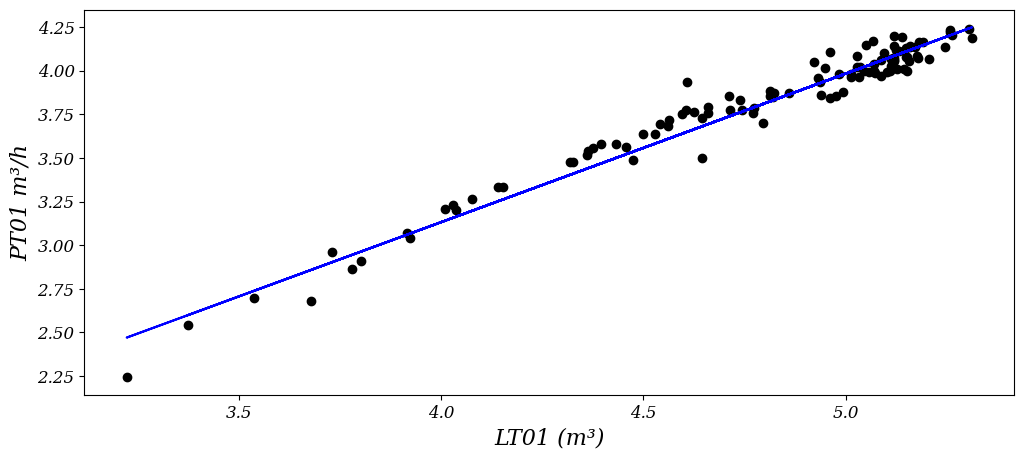

In [59]:
# my_lm = LinearRegression()
# lm_trn = my_lm.fit(X =endog_l_trn, y = endog_trn)
# lm_vld = my_lm.fit(X =endog_l_vld, y = endog_vld)
# lm_tst = my_lm.fit(X =endog_l_tst, y = endog_tst)
# lm = my_lm.fit(X =endog_l, y = endog)
# lr_trn = lm_trn.predict(endog_l_trn+pv)
# lr_vld = lm_vld.predict(endog_l_vld+pv)
# lr_tst = lm_tst.predict(endog_l_tst+pv)
# lr = lm_tst.predict(endog_l+pv)

plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.scatter(endog_l_tst, endog_tst, color = 'black')
plt.plot(endog_l_tst, lr_tst, 'b')
plt.xlabel(f'{rt}',fontsize = 16)
plt.ylabel(f'PT01 m³/h',fontsize = 16)
plt.savefig(f"LR {rt}.png", dpi=1000)
plt.show()



Coeficiente R²: 0.3062


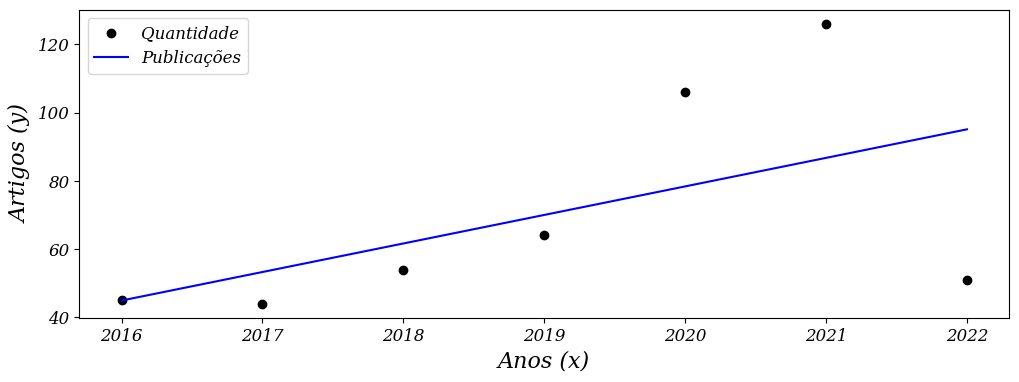

In [60]:
rg = pd.read_csv('regressão linear.csv', sep = ';')
# rg.set_index('Ano', inplace = True)

X = rg[['Ano']]
Y = rg['quantidade de artigo']

rg1 = my_lm.fit(X, Y)
reg = rg1.predict(X)

r_squared = r2_score(Y, reg)
print(f'Coeficiente R²: {r_squared:2.4f}')

plt.figure(figsize = (12,4))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.scatter(X, Y, color = 'black')
plt.plot(X, reg, 'b')
plt.xlabel('Anos (x)',fontsize = 16)
plt.ylabel('Artigos (y)',fontsize = 16)
plt.legend(['Quantidade', 'Publicações'], loc='upper left')
plt.savefig("regressão linear dos artigos baseados nos anos.pdf", dpi=500)
plt.show()

# Optuna

In [61]:
# import optuna

# def objective(trial):
#     x = trial.suggest_float('x', -10, 10)
#     return (x - 2) ** 2

# study = optuna.create_study()
# study.optimize(objective, n_trials=100)

# study.best_params  # E.g. {'x': 2.002108042}

In [62]:
# opt = BayesSearchCV(
#     XGBRegressor(),
#        {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,20),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        },
#        n_iter=52,
#        random_state=0)
# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

In [63]:
# opt = XGBRegressor()
# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

In [64]:

# opt.fit(exog_trn, endog_trn)

In [65]:
# opt = BayesSearchCV(
#     LGBMRegressor(),
#        {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,8),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        },
#        n_iter=32,
#        random_state=0)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

In [66]:
# from sklearn.model_selection import RandomizedSearchCV

# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(XGBRegressor(), param_space, n_iter=32,
#                                         scoring="accuracy", verbose=True, cv=5,
#                                         n_jobs=-1, random_state=42)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

# Grid

In [67]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'bootstrap': [True],
#      'max_depth': [2, 500],
#      'max_features': ['auto', 'sqrt', 'log2'],
#      'min_samples_leaf': [2, 40],
#      'min_samples_split': [2, 40],
#      'n_estimators': [100,5650]
#     }
     

# forest_clf = XGBRegressor()

# opt = GridSearchCV(my_xgb, param_grid, cv=30,
#                                   scoring="neg_mean_absolute_percentage_error",
#                                   return_train_score=True,
#                                   verbose=True,
#                                   n_jobs=-1)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

# # melhor otimização xgb


In [68]:
# print(opt.best_params_)


In [69]:
# print(opt.best_estimator_)


In [70]:
# print(opt.best_score_)

In [71]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'bootstrap': [True],
#      'max_depth': [2, 500],
#      'max_features': ['auto', 'sqrt', 'log2'],
#      'min_samples_leaf': [2, 40],
#      'min_samples_split': [2, 40],
#      'n_estimators': [100,5650]
#     }
     


# opt = GridSearchCV(my_lgbm, param_grid, cv=30,
#                                   scoring="neg_mean_absolute_percentage_error",
#                                   return_train_score=True,
#                                   verbose=True,
#                                   n_jobs=-1)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100


In [72]:
# print(opt.best_params_)

In [73]:
# print(opt.best_estimator_)

In [74]:
# print(opt.best_score_)

In [75]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'bootstrap': [True],
#      'max_depth': [2, 500],
#      'max_features': ['auto', 'sqrt', 'log2'],
#      'min_samples_leaf': [2, 40],
#      'min_samples_split': [2, 40],
#      'n_estimators': [100,5650]
#     }
     



# opt = GridSearchCV(my_rf, param_grid, cv=4,
#                                   scoring="neg_mean_absolute_percentage_error",
#                                   return_train_score=True,
#                                   verbose=True,
#                                   n_jobs=-1)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100


In [76]:
# print(opt.best_params_)

In [77]:
# print(opt.best_estimator_)

In [78]:
# print(opt.best_score_)

# Randomizer

In [79]:
# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(my_xgb, param_space, n_iter=32,
#                                         scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#                                         n_jobs=-1, random_state=122)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)


In [80]:
# print(opt.best_params_)


In [81]:
# print(opt.best_estimator_)


In [82]:
# print(opt.best_score_)


In [83]:
# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(my_lgbm, param_space, n_iter=32,
#                                         scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#                                         n_jobs=-1, random_state=122)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)

In [84]:
# print(opt.best_params_)

In [85]:
# print(opt.best_estimator_)

In [86]:
# print(opt.best_score_*100)

In [87]:
# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(my_rf, param_space, n_iter=32,
#                                         scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#                                         n_jobs=-1, random_state=122)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)

# #melhor otimização rf


In [88]:
# print(opt.best_params_)


In [89]:
# print(opt.best_estimator_)


In [90]:
# print(opt.best_score_)


# Bayes

In [91]:
# opt = BayesSearchCV(
#     LGBMRegressor(),
#        {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,8),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        },
#        n_iter=32,
#        random_state=0)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

In [92]:

# search_space = {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,8),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        "bootstrap": Categorical([True, False]), 
#         "max_depth": Integer(6, 40), 
#         "max_features": Categorical(['auto', 'sqrt','log2']), 
#         "min_samples_leaf": Integer(2, 30),
#         "min_samples_split": Integer(2,20),
#         "n_estimators": Integer(5, 200)
#        }

# opt = BayesSearchCV(my_xgb, search_space, 
#        n_iter=32, scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#        random_state=122)
       
# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)


In [93]:

# search_space = {"bootstrap": Categorical([True, False]), 
#         "max_depth": Integer(6, 40), 
#         "max_features": Categorical(['auto', 'sqrt','log2']), 
#         "min_samples_leaf": Integer(2, 30),
#         "min_samples_split": Integer(2,20),
#         "n_estimators": Integer(50, 200)
#     }

# opt = BayesSearchCV(my_xgb, search_space, 
#        n_iter=32, scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#        random_state=122)
       
# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)


In [94]:

# search_space = {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,8),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        "bootstrap": Categorical([True, False]), 
#         "max_depth": Integer(6, 40), 
#         "max_features": Categorical(['auto', 'sqrt','log2']), 
#         "min_samples_leaf": Integer(2, 30),
#         "min_samples_split": Integer(2,20),
#         "n_estimators": Integer(50, 200)
#     }

# opt = BayesSearchCV(my_lgbm, search_space, 
#        n_iter=32, scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#        random_state=122)
       
# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)


In [95]:

# search_space = {"bootstrap": Categorical([True, False]), 
#        "max_depth": Integer(6, 40), 
#        "max_features": Categorical(['auto', 'sqrt','log2']), 
#        "min_samples_leaf": Integer(2, 30),
#        "min_samples_split": Integer(2,20),
#        "n_estimators": Integer(50, 200)
#     }

# opt = BayesSearchCV(my_rf, search_space, 
#        n_iter=32, scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#        random_state=122)
       
# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)


# Cross Validation

In [96]:
crv(my_xgb, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

[19:12:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[19:12:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[19:12:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[19:12:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_

-3.014984080188712

In [97]:
crv(my_lgbm, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Un

-3.049446875210436

In [98]:
crv(my_lm, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

-1.8488063087622668

In [99]:
crv(my_rf, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

-2.94471299870622

#  Comparação Modelos Violino

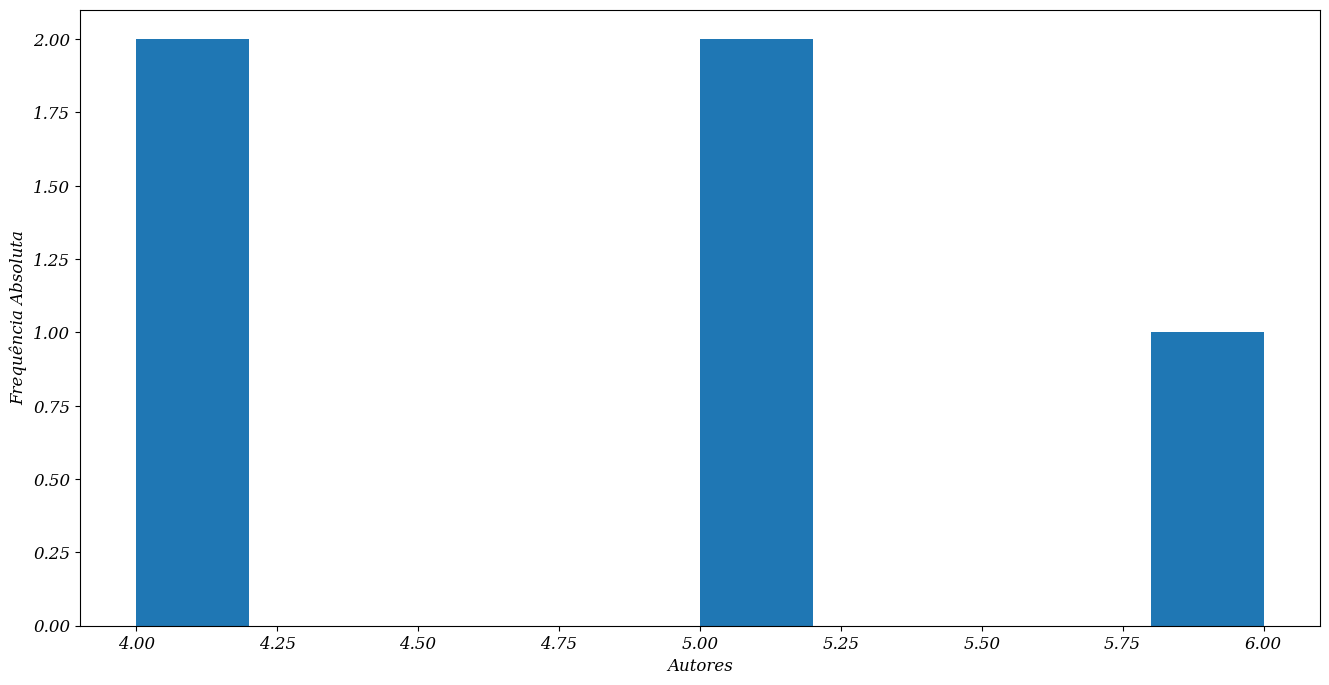

In [100]:
artigos=[6,5,5,4,4]
plt.xlabel('Autores')
plt.ylabel('Frequência Absoluta')
plt.hist(artigos)
plt.show()

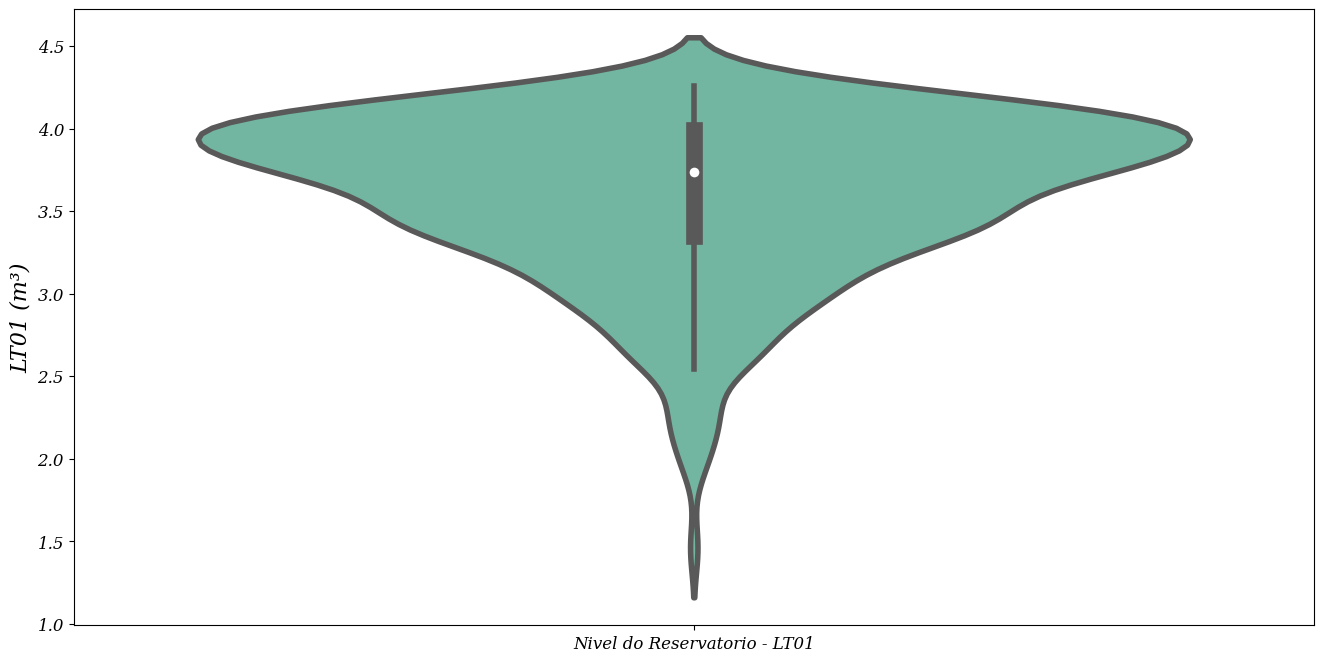

In [122]:
sns.violinplot(data = df['NIVEL DO RESERVATÓRIO - LT01'], linewidth = 4, palette="Set2")
x = [0]
labels = ['Nivel do Reservatorio - LT01']

plt.xticks(x, labels)
plt.ylabel(rt , fontsize = 16)
plt.savefig(f"viol.pdf", dpi=500)
plt.show()

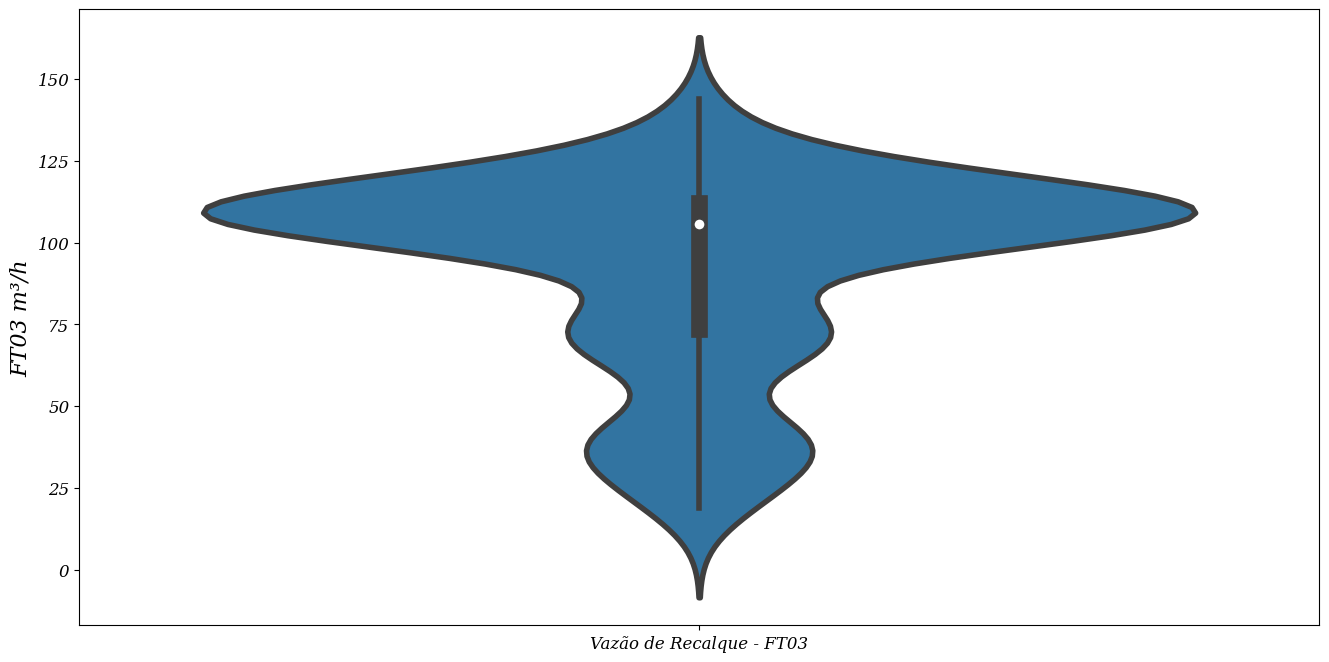

In [123]:
sns.violinplot(data = df['VAZÃO DE RECALQUE - FT03'],linewidth = 4)
x = [0]
labels = ['Vazão de Recalque - FT03']
plt.xticks(x, labels)
plt.ylabel('FT03 m³/h' , fontsize = 16)
plt.savefig(f"ft03.pdf", dpi=500)
plt.show()

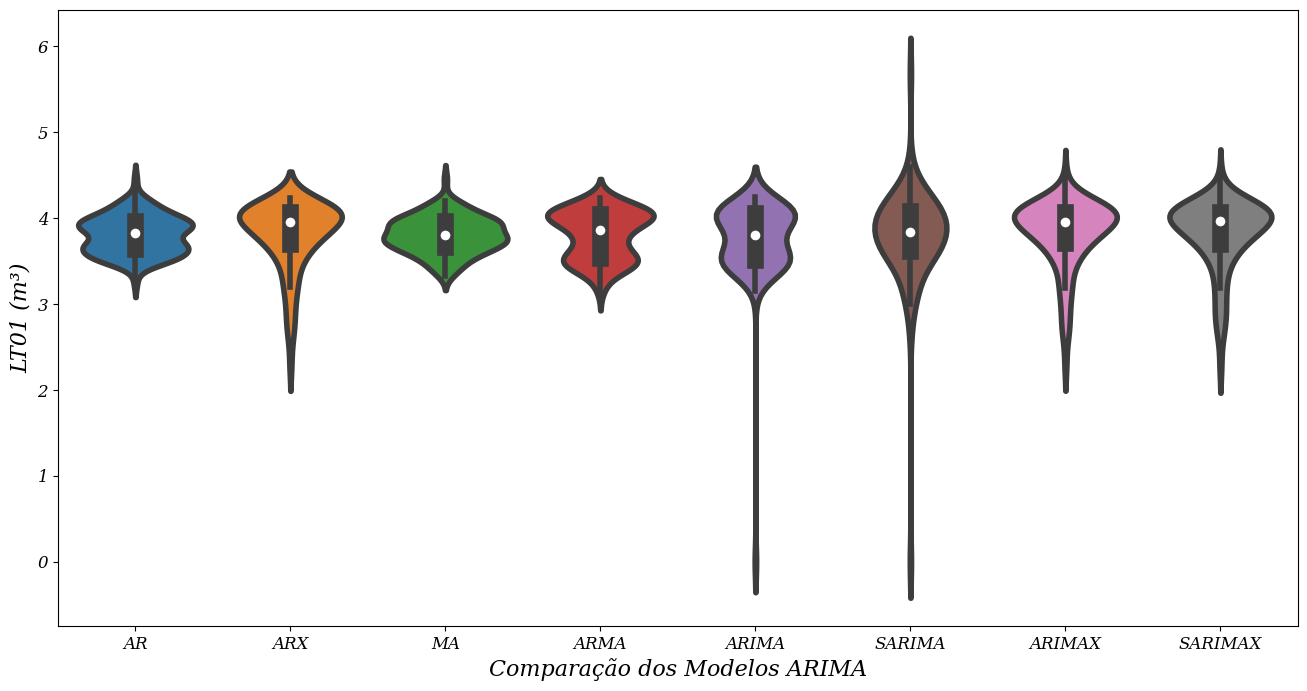

In [124]:
sns.violinplot(data = [ar_tst, arx_tst, ma_tst, arma_tst, arima_tst, sarima_tst, arimax_tst, sarimax_tst], 
               linewidth = 4)
x = [0,1,2,3,4,5,6,7]
labels = ['AR', 'ARX', 'MA', 'ARMA', 'ARIMA', 'SARIMA', 'ARIMAX', 'SARIMAX']
plt.xticks(x, labels)
plt.ylabel(rt , fontsize = 16)
plt.xlabel('Comparação dos Modelos ARIMA', fontsize = 16)
plt.savefig(f"{pv}-modelos-arima.pdf", dpi=500)
plt.show()

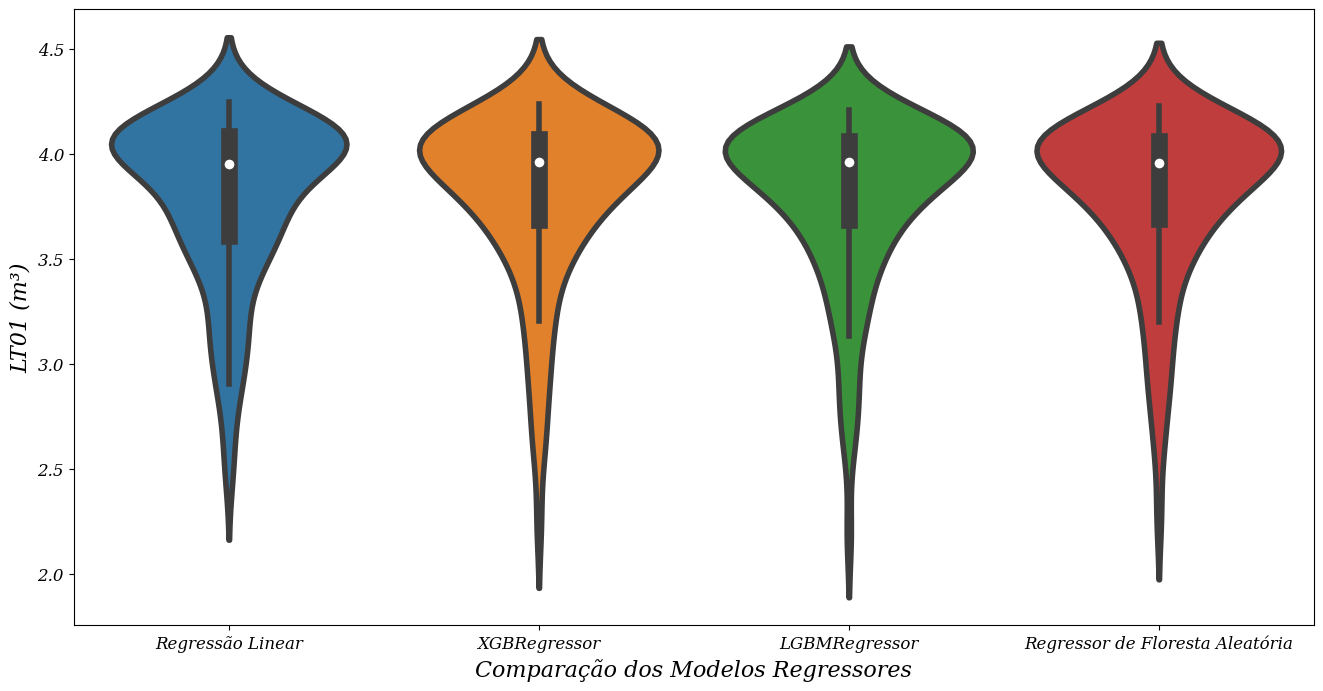

In [125]:
sns.violinplot(data = [lr_tst, xgb_tst, lgbm_tst, rf_tst], linewidth = 4)
x = [0,1,2,3]
labels = ['Regressão Linear', 'XGBRegressor', 'LGBMRegressor', 'Regressor de Floresta Aleatória']
plt.xticks(x, labels)
plt.ylabel(rt , fontsize = 16)
plt.xlabel('Comparação dos Modelos Regressores', fontsize = 16)
plt.savefig(f"{pv}-violin-LR-XGB-LGBM-RF.pdf", dpi=500)
plt.show()

#  Comparação regressão 

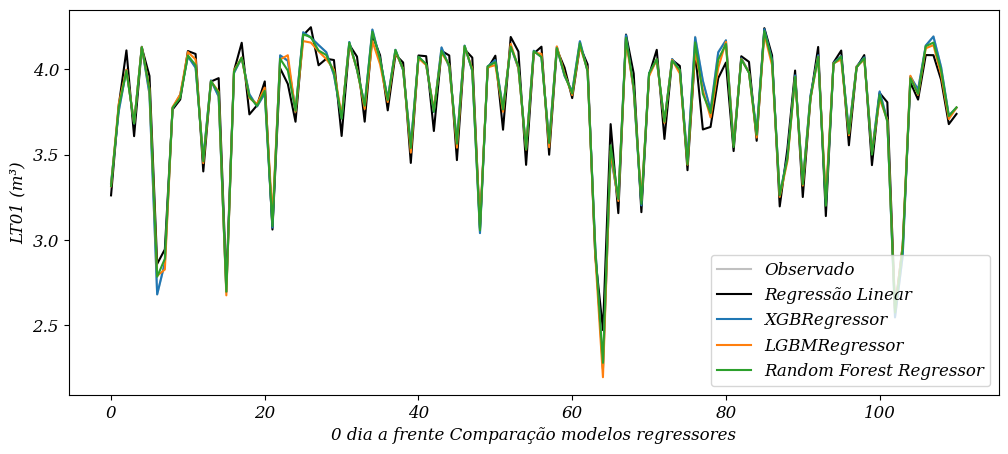

In [126]:
# x = range(0,len(endog_tst),50)
# value = endog_tst.index[range(0,len(endog_tst),50)]
plt.figure(figsize = (12,5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(lr_tst), 'black')
plt.plot(list(xgb_tst))
plt.plot(list(lgbm_tst))
plt.plot(list(rf_tst))
# plt.yticks(fontsize = 12)
# plt.xticks(x, value, fontsize = 10)
plt.xlabel(pvl+' Comparação modelos regressores', fontsize = 12)
plt.legend(['Observado','Regressão Linear', 'XGBRegressor', 'LGBMRegressor', 'Random Forest Regressor'])
plt.ylabel(rt)
plt.savefig(f"{pv}-LR-XGB-LGBM-RF.pdf", dpi=500)
plt.show()

# Redes neurais

## LSTM

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1200)              5769600   
                                                                 
 dense_1 (Dense)             (None, 204)               245004    
                                                                 
Total params: 6,014,604
Trainable params: 6,014,604
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
6/6 [==============================] - 4s 177ms/step - loss: 2.5874 - mean_absolute_error: 2.5874 - val_loss: 1.1815 - val_mean_absolute_error: 1.1815
Epoch 2/5
6/6 [==============================] - 0s 53ms/step - loss: 1.1130 - mean_absolute_error: 1.1130 - val_loss: 0.8912 - val_mean_absolute_error: 0.8912
Epoch 3/5
6/6 [==============================] - 0s 49ms/step - loss: 0.7993 - mean_absolute_error: 0.7993 - val_loss: 

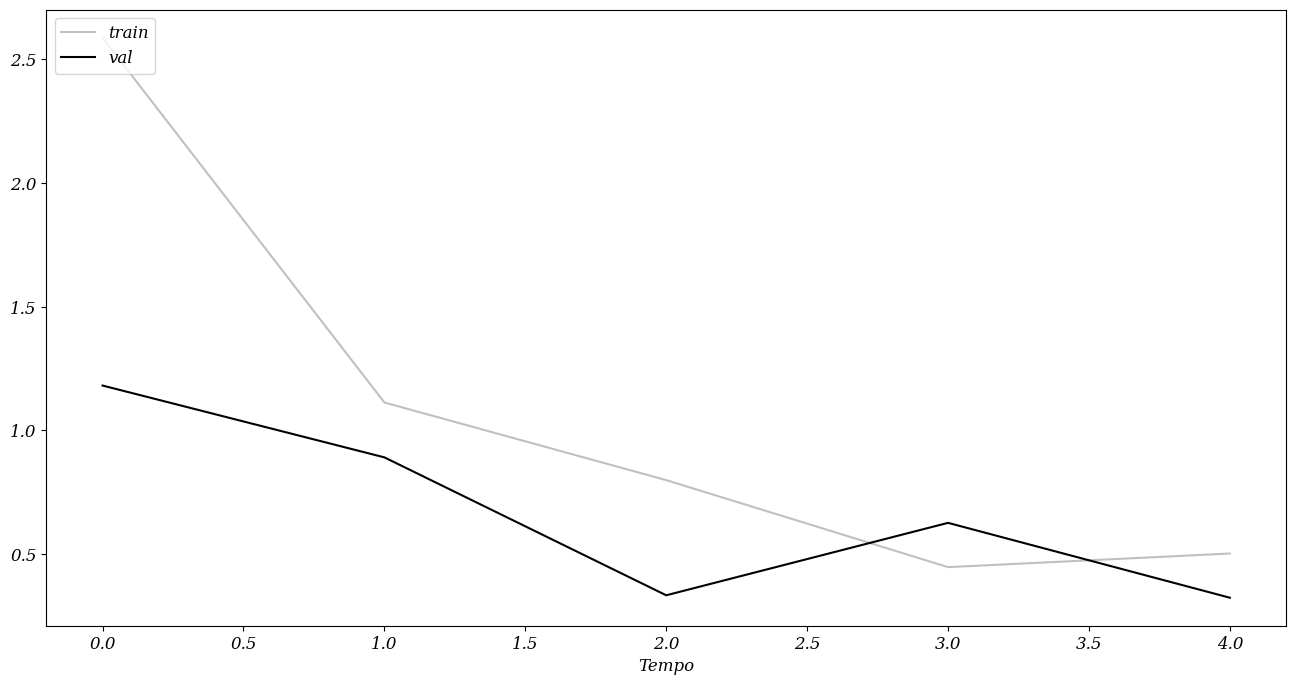

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

n_samples = endog_trn.shape[0]
n_timesteps = endog_trn.shape[0]
n_steps = endog_trn.shape[0]
n_features = 1

# endog_trn_rs = endog_trn.reshape(n_samples, n_timesteps, n_features )
# endog_tst_rs = endog_tst.reshape(endog_tst.shape[0], n_timesteps, n_features )

random.seed(42)
batch_size = 32
simple_model = Sequential([LSTM(1200, activation='tanh',input_shape=(n_timesteps, n_features)),Dense(endog_trn.shape[0])])
simple_model.summary()
simple_model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.01),
loss='mean_absolute_error',
metrics=['mean_absolute_error'],
)
smod_history = simple_model.fit(endog_trn, endog_trn,
                                validation_split=0.2,
                                epochs=5,
                                batch_size=batch_size,
                                shuffle = True)
                                
preds = simple_model.predict(endog_tst+pv)
# print(mean_absolute_error(preds, endog_tst))
plt.plot(smod_history.history['loss'], 'silver')
plt.plot(smod_history.history['val_loss'], 'black')
plt.xlabel('Tempo')
plt.legend(['train', 'val'], loc='upper left')
plt.show()




# Salva Erro


In [128]:

pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {
        'MAPE':[ mape_AR_trn, mape_ARX_trn, mape_MA_trn ,mape_ARMA_trn, 
        mape_ARIMA_trn,mape_SARIMA_trn, mape_arimax_trn,mape_sarimax_trn, mape_lr_trn, mape_rf_trn, mape_xgb_trn, 
        mape_lgbm_trn],
        'MAE':[ mae_AR_trn, mae_ARX_trn, mae_MA_trn, mae_ARMA_trn,mae_ARIMA_trn,
        mae_SARIMA_trn, mae_arimax_trn, mae_sarimax_trn, mae_lr_trn, mae_rf_trn, mae_xgb_trn, mae_lgbm_trn],
        'RMSE':[ rmse_AR_trn, rmse_ARX_trn, rmse_MA_trn, rmse_ARMA_trn,rmse_ARIMA_trn,
        rmse_SARIMA_trn,rmse_arimax_trn, rmse_sarimax_trn, rmse_lr_trn, rmse_rf_trn, rmse_xgb_trn, rmse_lgbm_trn],
},
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros treino.xlsx')
sarimax_erro


,MAPE,MAE,RMSE
AR,5.822,18.249,23.363
ARX,10.141,32.946,45.308
MA,5.640,17.558,22.383
ARMA,6.038,19.227,25.046
ARIMA,6.054,19.459,25.262
SARIMA,7.418,24.203,33.863
ARIMAX,10.161,33.005,45.471
SARIMAX,10.230,33.272,45.066
Linear Regression,21.216,92.800,93.186
Random Forest Regressor,0.791,2.465,4.588


In [129]:

pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {
        'MAPE':[ mape_AR_vld, mape_ARX_vld, mape_MA_vld, mape_ARMA_vld,mape_ARIMA_vld,
        mape_SARIMA_vld,mape_arimax_vld, mape_sarimax_vld, mape_lr_vld, mape_rf_vld, mape_xgb_vld, mape_lgbm_vld],
        'MAE':[ mae_AR_vld, mae_ARX_vld, mae_MA_vld, mae_ARMA_vld,mae_ARIMA_vld,
        mae_SARIMA_vld, mae_arimax_vld, mae_sarimax_vld, mae_lr_vld, mae_rf_vld, mae_xgb_vld, mae_lgbm_vld],
        'RMSE':[rmse_AR_vld, rmse_ARX_vld, rmse_MA_vld, rmse_ARMA_vld,rmse_ARIMA_vld,
        rmse_SARIMA_vld,rmse_arimax_vld, rmse_sarimax_vld, rmse_lr_vld, rmse_rf_vld, rmse_xgb_vld, rmse_lgbm_vld],
    },
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros validação.xlsx')
sarimax_erro


,MAPE,MAE,RMSE
AR,8.227,29.793,36.153
ARX,10.280,37.722,48.331
MA,8.551,30.940,36.987
ARMA,8.496,30.688,37.427
ARIMA,8.109,29.689,37.600
SARIMA,8.963,33.360,51.691
ARIMAX,10.213,37.457,48.153
SARIMAX,10.464,38.586,50.982
Linear Regression,20.726,97.757,98.017
Random Forest Regressor,0.357,1.274,2.162


In [130]:

pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {   
      
        'MAPE': [mape_AR_tst, mape_ARX_tst, mape_MA_tst, mape_ARMA_tst,mape_ARIMA_tst,
        mape_SARIMA_tst,mape_arimax_tst, mape_sarimax_tst, mape_lr_tst, mape_rf_tst, mape_xgb_tst, mape_lgbm_tst],
        'MAE': [mae_AR_tst, mae_ARX_tst, mae_MA_tst, mae_ARMA_tst,mae_ARIMA_tst,
        mae_SARIMA_tst, mae_arimax_tst, mae_sarimax_tst, mae_lr_tst, mae_rf_tst, mae_xgb_tst, mae_lgbm_tst],
        'RMSE':[rmse_AR_tst, rmse_ARX_tst, rmse_MA_tst, rmse_ARMA_tst,rmse_ARIMA_tst,
        rmse_SARIMA_tst,rmse_arimax_tst,rmse_sarimax_tst, rmse_lr_tst, rmse_rf_tst, rmse_xgb_tst, rmse_lgbm_tst],
    },
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros teste.xlsx')
sarimax_erro


,MAPE,MAE,RMSE
AR,9.186,32.716,38.598
ARX,10.971,38.963,50.317
MA,7.261,25.549,32.557
ARMA,9.812,35.046,42.347
ARIMA,9.285,33.307,40.436
SARIMA,9.657,35.244,45.159
ARIMAX,11.018,39.149,50.368
SARIMAX,11.116,39.541,51.203
Linear Regression,20.668,98.443,98.682
Random Forest Regressor,0.381,1.364,2.064


In [131]:

pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {
        "MAPE": [AR_mape, ARX_mape, MA_mape, ARMA_mape, ARIMA_mape, SARIMA_mape, arimax_mape, sarimax_mape, mape_lr, mape_rf,
         mape_xgb, mape_lgbm],


        "MAE": [AR_mae, ARX_mae, MA_mae, ARMA_mae, ARIMA_mae, SARIMA_mae, arimax_mae, sarimax_mae, mae_lr, mae_rf, mae_xgb, mae_lgbm],


        'RMSE': [ AR_rmse, ARX_rmse, MA_rmse ,ARMA_rmse, ARIMA_rmse, SARIMA_rmse, arimax_rmse, sarimax_rmse, rmse_lr, rmse_rf, 
        rmse_xgb, rmse_lgbm],


    },
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros todo.xlsx')
sarimax_erro


,MAPE,MAE,RMSE
AR,6.470,21.330,6.935
ARX,10.477,35.699,22.464
MA,7.231,23.488,30.282
ARMA,6.751,22.622,27.917
ARIMA,7.100,23.807,29.410
SARIMA,8.243,28.556,36.789
ARIMAX,10.480,35.692,47.492
SARIMAX,10.541,35.921,47.312
Linear Regression,20.982,95.202,95.562
Random Forest Regressor,0.606,1.965,3.698



# Teste significancia


In [132]:

from scipy import stats

#faça o teste de Friedman
friendma = stats.friedmanchisquare(df['FREQUENCIA BOMBA 1'], df['FREQUENCIA BOMBA 2'], df['FREQUENCIA BOMBA 3'],
       endog, df['VAZÃO DE ENTRADA- FT01'],
       df['VAZÃO DE GRAVIDADE - FT02'], df['VAZÃO DE RECALQUE - FT03'],
       df['PRESSÃO DE SUCÇÃO - PT01'], df['PRESSÃO DE RECALQUE - PT02'])

print(friendma)

import scikit_posthocs as sp

#combine three groups into one array
data = np.array([df['FREQUENCIA BOMBA 1'], df['FREQUENCIA BOMBA 2'], df['FREQUENCIA BOMBA 3'],
       endog, df['VAZÃO DE ENTRADA- FT01'],
       df['VAZÃO DE GRAVIDADE - FT02'], df['VAZÃO DE RECALQUE - FT03'],
       df['PRESSÃO DE SUCÇÃO - PT01'], df['PRESSÃO DE RECALQUE - PT02']])

#perform Nemenyi post-hoc test
print(sp.posthoc_nemenyi_friedman(data.T))



FriedmanchisquareResult(statistic=2545.5228639096376, pvalue=0.0)
      0     1     2     3     4     5     6     7     8
0 1.000 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
1 0.001 1.000 0.001 0.001 0.001 0.001 0.001 0.001 0.900
2 0.001 0.001 1.000 0.900 0.001 0.001 0.001 0.001 0.001
3 0.001 0.001 0.900 1.000 0.001 0.001 0.001 0.001 0.001
4 0.001 0.001 0.001 0.001 1.000 0.001 0.001 0.001 0.001
5 0.001 0.001 0.001 0.001 0.001 1.000 0.001 0.001 0.001
6 0.001 0.001 0.001 0.001 0.001 0.001 1.000 0.001 0.001
7 0.001 0.001 0.001 0.001 0.001 0.001 0.001 1.000 0.001
8 0.001 0.900 0.001 0.001 0.001 0.001 0.001 0.001 1.000


# Ljung Box

In [133]:
ar1 = str(lj_ar_df)
arx1 = str(lj_arx_df)
ma1 = str(lj_ma_df)
arma1 = str(lj_arma_df)
arima1 = str(lj_arima_df)
arimax1 = str(lj_arimax_df)
sarima1 = str(lj_sarima_df)
sarimax1 = str(lj_sarimax_df)


In [134]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung.xlsx')
ljung


,Estatística de Teste,Valor De p
ARX,0.744,1.000
AR,6.607,0.762
MA,71.338,0.000
ARMA,24.353,0.007
ARIMA,24.353,0.007
SARIMA,24.353,0.007
ARIMAX,0.253,1.000
SARIMAX,1.595,0.999


In [135]:
ar1 = str(lj_ar_trn)
arx1 = str(lj_arx_trn)
ma1 = str(lj_ma_trn)
arma1 = str(lj_arma_trn)
arima1 = str(lj_arima_trn)
arimax1 = str(lj_arimax_trn)
sarima1 = str(lj_sarima_trn)
sarimax1 = str(lj_sarimax_trn)


In [136]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung_trn.xlsx')
ljung


,Estatística de Teste,Valor De p
ARX,0.328,1.000
AR,3.419,0.970
MA,8.706,0.560
ARMA,1.463,0.999
ARIMA,0.681,1.000
SARIMA,2.019,0.996
ARIMAX,0.254,1.000
SARIMAX,1.169,1.000


In [137]:
ar1 = str(lj_ar_tst)
arx1 = str(lj_arx_tst)
ma1 = str(lj_ma_tst)
arma1 = str(lj_arma_tst)
arima1 = str(lj_arima_tst)
arimax1 = str(lj_arimax_tst)
sarima1 = str(lj_sarima_tst)
sarimax1 = str(lj_sarimax_tst)


In [138]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung_tst.xlsx')
ljung


,Estatística de Teste,Valor De p
ARX,1.826,0.998
AR,0.075,0.434
MA,22.404,0.013
ARMA,2.089,0.996
ARIMA,7.647,0.663
SARIMA,6.531,0.769
ARIMAX,0.568,1.000
SARIMAX,0.800,1.000


In [139]:
ar1 = str(lj_ar_vld)
arx1 = str(lj_arx_vld)
ma1 = str(lj_ma_vld)
arma1 = str(lj_arma_vld)
arima1 = str(lj_arima_vld)
arimax1 = str(lj_arimax_vld)
sarima1 = str(lj_sarima_vld)
sarimax1 = str(lj_sarimax_vld)


In [140]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung_vld.xlsx')
ljung


,Estatística de Teste,Valor De p
ARX,3.205,0.976
AR,4.580,0.917
MA,2.658,0.988
ARMA,6.237,0.795
ARIMA,5.543,0.852
SARIMA,14.345,0.158
ARIMAX,0.194,1.000
SARIMAX,0.465,1.000
